1️⃣ Setup & Drive Mount

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 2️⃣ Importing Libraries

In [ ]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
from torchvision import models, transforms

# CPU optimization
torch.set_num_threads(4)
computation_device = torch.device("cpu")
print(f"🖥️ Computation device: {computation_device}")

🖥️ Computation device: cpu


3️⃣ Setting Paths

In [ ]:
# Define paths
data_path = "/content/drive/My Drive/property_prices.csv"
IMAGE_DIRECTORY= "/content/drive/My Drive/Images"

📊 4️⃣ Loading and Inspecting the Text Dataset

In [ ]:
# Load dataset
property_data = pd.read_csv(data_path)
print("Shape:", property_data.shape)
property_data.head()

Shape: (1613, 15)


,scraped_page,title,detail_url,currency,price,building_area,building_unit,land_area,land_unit,property_type,bedrooms,bathrooms,location,image_count,image_filenames
0,1,Developers Dream,https://www.property.co.zw/for-sale/houses-bls...,USD,190000.0,180.0,m²,1352.0,m²,3 Bedroom House,3.0,1.0,Belvedere,1,df03d95d0b_0.webp
1,1,2 Bedroom Flat In Prime Avondale Location,https://www.property.co.zw/for-sale/flats-apar...,USD,95000.0,120.0,m²,NaN,m²,2 Bedroom Flat,2.0,1.0,Avondale,1,41c6aa94bc_0.webp
2,1,"Charming 3-Bedroom Family Home in Mabvazuva, R...",https://www.property.co.zw/for-sale/houses-p19...,USD,105000.0,3410.0,m²,410.0,m²,3 Bedroom House,3.0,NaN,NaN,1,483115d1c1_0.webp
3,1,The Strand office land in Borrowdale.,https://www.property.co.zw/for-sale/commercial...,USD,875000.0,NaN,m²,8000.0,m²,NaN,NaN,NaN,Borrowdale,1,ac7160491a_0.webp
4,1,Stands for Sale,https://www.property.co.zw/for-sale/residentia...,USD,60000.0,442.0,m²,442.0,m²,NaN,NaN,NaN,Harare,1,1d7f22fc05_0.webp



🧹 5️⃣ Cleaning & Preprocessing the Text Data

In [ ]:

import os
from sklearn.preprocessing import LabelEncoder

print("🧹 Cleaning and preprocessing data (retain only rows with existing images)...")

cleaned_data = property_data.copy()

# Drop unnecessary columns
cols_to_drop = ['detail_url', 'scraped_page']
cleaned_data = cleaned_data.drop(columns=[c for c in cols_to_drop if c in cleaned_data.columns])

# Basic text cleanup
for col in cleaned_data.select_dtypes(include=['object']).columns:
    cleaned_data[col] = cleaned_data[col].astype(str).str.strip()

# Price → numeric, missing → 0
if 'price' in cleaned_data.columns:
    cleaned_data['price'] = (
        cleaned_data['price'].astype(str)
        .str.replace(r'[\$,]', '', regex=True)
    )
    cleaned_data['price'] = pd.to_numeric(cleaned_data['price'], errors='coerce').fillna(0)

# Numeric columns → numeric safe, missing → 0
num_cols = ['building_area', 'land_area', 'bedrooms', 'bathrooms']
for col in num_cols:
    if col in cleaned_data.columns:
        cleaned_data[col] = pd.to_numeric(cleaned_data[col], errors='coerce').fillna(0)

# Encode categorical only if present, missing → "Unknown"
cat_cols = ['currency', 'property_type']
for col in cat_cols:
    if col in cleaned_data.columns:
        cleaned_data[col] = cleaned_data[col].replace("nan", None).fillna("Unknown")
        cleaned_data[col] = LabelEncoder().fit_transform(cleaned_data[col].astype(str))

# Fill any remaining NaNs in text
for col in cleaned_data.select_dtypes(include=['object']).columns:
    cleaned_data[col] = cleaned_data[col].fillna("")

# 🔥 Retain only rows with existing image files
IMAGE_FOLDER = "/content/drive/My Drive/Images"
existing_images = set(os.listdir(IMAGE_FOLDER))  # actual files in folder
cleaned_data = cleaned_data[cleaned_data['image_filenames'].isin(existing_images)].reset_index(drop=True)

print(f"✅ Data cleaning completed. Records with existing images: {cleaned_data.shape[0]}")
cleaned_data.info()

🧹 Cleaning and preprocessing data (retain only rows with existing images)...
✅ Data cleaning completed. Records with existing images: 468
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            468 non-null    object 
 1   currency         468 non-null    int64  
 2   price            468 non-null    float64
 3   building_area    468 non-null    float64
 4   building_unit    468 non-null    object 
 5   land_area        468 non-null    float64
 6   land_unit        468 non-null    object 
 7   property_type    468 non-null    int64  
 8   bedrooms         468 non-null    float64
 9   bathrooms        468 non-null    float64
 10  location         468 non-null    object 
 11  image_count      468 non-null    int64  
 12  image_filenames  468 non-null    object 
dtypes: float64(5), int64(3), object(5)
memory usage: 47.7+ KB



6️⃣ Separate Features & Target

In [ ]:

print("🎯 Separating features and target variable...")

# Define columns to exclude from features
exclude_columns = ['price', 'title', 'image_filenames', 'building_unit', 'land_unit', 'location']
feature_columns = [col for col in cleaned_data.columns if col not in exclude_columns]

print(f"📋 Feature columns: {feature_columns}")

# Create feature matrix and target vector
X_features = cleaned_data[feature_columns]
y_target = cleaned_data['price']

print(f"📊 Feature matrix shape: {X_features.shape}")
print(f"🎯 Target vector shape: {y_target.shape}")

# Scale numeric features
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X_features)

print("✅ Feature scaling completed")

🎯 Separating features and target variable...
📋 Feature columns: ['currency', 'building_area', 'land_area', 'property_type', 'bedrooms', 'bathrooms', 'image_count']
📊 Feature matrix shape: (468, 7)
🎯 Target vector shape: (468,)
✅ Feature scaling completed


7️⃣ Image Preprocessing

8️⃣ Image Feature Extraction (21 Models)

In [ ]:

import os
from PIL import Image
from torchvision import transforms

print("🖼️ Configuring image preprocessing...")

# Standard CNN transform
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 🔥 NEW: Load ACTUAL filenames inside the Images/ folder
IMAGE_FOLDER = "/content/drive/My Drive/Images"
actual_image_files = {os.path.splitext(f)[0]: f for f in os.listdir(IMAGE_FOLDER)}

def load_and_preprocess_image(requested_name):
    """
    Load & preprocess an image using ONLY real files in Images/.
    requested_name can be anything – we match to closest real file.
    """

    # --- 1️⃣ Try exact match first ---
    base = os.path.splitext(os.path.basename(requested_name))[0]

    if base in actual_image_files:
        real_path = os.path.join(IMAGE_FOLDER, actual_image_files[base])
    else:
        # --- 2️⃣ If not found, warn and skip ---
        print(f"⚠️ '{requested_name}' not found in Images/. Skipping.")
        return None

    # --- 3️⃣ Load the actual image ---
    try:
        img = Image.open(real_path).convert("RGB")
        return image_transform(img).unsqueeze(0)
    except Exception as e:
        print(f"⚠️ Error loading real file '{real_path}': {e}")
        return None

print("✅ Image processing configured using REAL folder contents.")

🖼️ Configuring image preprocessing...
✅ Image processing configured using REAL folder contents.


Model 1 - AlexNet Feature Extraction

In [ ]:

print("🔍 Extracting features with AlexNet...")

try:
    alexnet_model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    # Remove final classifier layer
    alexnet_model.classifier = nn.Sequential(
        *list(alexnet_model.classifier.children())[:-1]
    )
    alexnet_model.eval()

    alexnet_features = []

    for image_file in tqdm(cleaned_data['image_filenames'], desc="AlexNet"):

        #Pass only the *name* — loader handles actual path
        processed_image = load_and_preprocess_image(image_file)

        if processed_image is not None:
            with torch.no_grad():
                features = alexnet_model(processed_image).flatten().numpy()
                alexnet_features.append(features)
        else:
            # Still create 4096-dim zero vector for missing/unmatched images
            alexnet_features.append(np.zeros(4096))

    alexnet_features = np.array(alexnet_features)
    print(f"✅ AlexNet features extracted: {alexnet_features.shape}")

except Exception as e:
    print(f"❌ AlexNet feature extraction failed: {e}")

alexnet_features

🔍 Extracting features with AlexNet...
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 155MB/s]
AlexNet: 100%|██████████| 468/468 [00:58<00:00,  8.05it/s]

✅ AlexNet features extracted: (468, 4096)


array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 1.1253443, ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 3.0690014, ..., 0.       , 0.       ,
        1.7575005],
       [0.       , 0.       , 2.712745 , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)


Model 2 - Network In Network (NIN) Feature Extraction

In [ ]:
print("🔍 Extracting features with Network In Network...")

try:
    # NIN is available in timm
    !pip install timm -q
    import timm

    nin_model = timm.create_model('nin', pretrained=True, num_classes=0)  # Remove classifier
    nin_model.eval()

    nin_features = []
    for image_file in tqdm(cleaned_data['image_filenames'], desc="NIN"):
        image_path = os.path.join(IMAGE_DIRECTORY, image_file)
        processed_image = load_and_preprocess_image(image_path)

        if processed_image is not None:
            with torch.no_grad():
                features = nin_model(processed_image).flatten().numpy()
                nin_features.append(features)
        else:
            nin_features.append(np.zeros(1000))  # NIN output dimension

    nin_features = np.array(nin_features)
    print(f"✅ NIN features extracted: {nin_features.shape}")

except Exception as e:
    print(f"❌ NIN feature extraction failed: {e}")
    nin_features = np.zeros((len(cleaned_data), 1000))

🔍 Extracting features with Network In Network...
❌ NIN feature extraction failed: Unknown model (nin)


Model 3 - ZINet Feature Extraction

In [ ]:

print("🔍 Extracting features with ZINet (using ResNet as substitute)...")

try:
    # Using ResNet50 as substitute for ZINet
    zinet_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    zinet_model = nn.Sequential(*list(zinet_model.children())[:-1])  # Remove final layer
    zinet_model.eval()

    zinet_features = []
    for image_file in tqdm(cleaned_data['image_filenames'], desc="ZINet"):
        image_path = os.path.join(IMAGE_DIRECTORY, image_file)
        processed_image = load_and_preprocess_image(image_path)

        if processed_image is not None:
            with torch.no_grad():
                features = zinet_model(processed_image).flatten().numpy()
                zinet_features.append(features)
        else:
            zinet_features.append(np.zeros(2048))

    zinet_features = np.array(zinet_features)
    print(f"✅ ZINet features extracted: {zinet_features.shape}")

except Exception as e:
    print(f"❌ ZINet feature extraction failed: {e}")
    zinet_features = np.zeros((len(cleaned_data), 2048))

🔍 Extracting features with ZINet (using ResNet as substitute)...
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s]
ZINet: 100%|██████████| 468/468 [02:34<00:00,  3.02it/s]

✅ ZINet features extracted: (468, 2048)


Model 4 - VGG Feature Extraction

In [ ]:


print("🔍 Extracting features with VGG networks...")

# VGG16
try:
    vgg16_model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    vgg16_model.classifier = nn.Sequential(*list(vgg16_model.classifier.children())[:-1])
    vgg16_model.eval()

    vgg16_features = []
    for image_file in tqdm(cleaned_data['image_filenames'], desc="VGG16"):
        image_path = os.path.join(IMAGE_DIRECTORY, image_file)
        processed_image = load_and_preprocess_image(image_path)

        if processed_image is not None:
            with torch.no_grad():
                features = vgg16_model(processed_image).flatten().numpy()
                vgg16_features.append(features)
        else:
            vgg16_features.append(np.zeros(4096))

    vgg16_features = np.array(vgg16_features)
    print(f"✅ VGG16 features extracted: {vgg16_features.shape}")

except Exception as e:
    print(f"❌ VGG16 feature extraction failed: {e}")
    vgg16_features = np.zeros((len(cleaned_data), 4096))

# VGG19
try:
    vgg19_model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)
    vgg19_model.classifier = nn.Sequential(*list(vgg19_model.classifier.children())[:-1])
    vgg19_model.eval()

    vgg19_features = []
    for image_file in tqdm(cleaned_data['image_filenames'], desc="VGG19"):
        image_path = os.path.join(IMAGE_DIRECTORY, image_file)
        processed_image = load_and_preprocess_image(image_path)

        if processed_image is not None:
            with torch.no_grad():
                features = vgg19_model(processed_image).flatten().numpy()
                vgg19_features.append(features)
        else:
            vgg19_features.append(np.zeros(4096))

    vgg19_features = np.array(vgg19_features)
    print(f"✅ VGG19 features extracted: {vgg19_features.shape}")

except Exception as e:
    print(f"❌ VGG19 feature extraction failed: {e}")
    vgg19_features = np.zeros((len(cleaned_data), 4096))

🔍 Extracting features with VGG networks...
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:09<00:00, 55.8MB/s]
VGG16: 100%|██████████| 468/468 [05:50<00:00,  1.33it/s]


✅ VGG16 features extracted: (468, 4096)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:08<00:00, 69.5MB/s]
VGG19: 100%|██████████| 468/468 [06:49<00:00,  1.14it/s]

✅ VGG19 features extracted: (468, 4096)


Model 5 - GoogLeNet Feature Extraction

In [ ]:
print("🔍 Extracting features with GoogLeNet...")

try:
    googlenet_model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)
    googlenet_model.fc = nn.Identity()  # Remove final fully connected layer
    googlenet_model.eval()

    googlenet_features = []
    for image_file in tqdm(cleaned_data['image_filenames'], desc="GoogLeNet"):
        image_path = os.path.join(IMAGE_DIRECTORY, image_file)
        processed_image = load_and_preprocess_image(image_path)

        if processed_image is not None:
            with torch.no_grad():
                features = googlenet_model(processed_image).flatten().numpy()
                googlenet_features.append(features)
        else:
            googlenet_features.append(np.zeros(1024))

    googlenet_features = np.array(googlenet_features)
    print(f"✅ GoogLeNet features extracted: {googlenet_features.shape}")

except Exception as e:
    print(f"❌ GoogLeNet feature extraction failed: {e}")
    googlenet_features = np.zeros((len(cleaned_data), 1024))

🔍 Extracting features with GoogLeNet...
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 159MB/s]
GoogLeNet: 100%|██████████| 468/468 [01:38<00:00,  4.73it/s]

✅ GoogLeNet features extracted: (468, 1024)


Model 6 - Inception-V3 Feature Extraction

In [ ]:


print("🔍 Extracting features with Inception-V3...")

try:
    inception_v3_model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1, aux_logits=False)
    inception_v3_model.fc = nn.Identity()  # Remove classification layer
    inception_v3_model.eval()

    # Inception V3 requires 299x299 input
    inception_transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    inception_v3_features = []
    for image_file in tqdm(cleaned_data['image_filenames'], desc="InceptionV3"):
        image_path = os.path.join(IMAGE_DIRECTORY, image_file)
        try:
            image = Image.open(image_path).convert('RGB')
            processed_image = inception_transform(image).unsqueeze(0)

            with torch.no_grad():
                features = inception_v3_model(processed_image).flatten().numpy()
                inception_v3_features.append(features)
        except:
            inception_v3_features.append(np.zeros(2048))

    inception_v3_features = np.array(inception_v3_features)
    print(f"✅ Inception-V3 features extracted: {inception_v3_features.shape}")

except Exception as e:
    print(f"❌ Inception-V3 feature extraction failed: {e}")
    inception_v3_features = np.zeros((len(cleaned_data), 2048))

🔍 Extracting features with Inception-V3...
❌ Inception-V3 feature extraction failed: The parameter 'aux_logits' expected value True but got False instead.


Model 7 - Highway Network Feature Extraction

In [ ]:


print("🔍 Extracting features with Highway Network (using DenseNet as substitute)...")

try:
    # Using DenseNet as substitute for Highway Network
    highway_model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
    highway_model.classifier = nn.Identity()  # Remove classifier
    highway_model.eval()

    highway_features = []
    for image_file in tqdm(cleaned_data['image_filenames'], desc="HighwayNet"):
        image_path = os.path.join(IMAGE_DIRECTORY, image_file)
        processed_image = load_and_preprocess_image(image_path)

        if processed_image is not None:
            with torch.no_grad():
                features = highway_model(processed_image).flatten().numpy()
                highway_features.append(features)
        else:
            highway_features.append(np.zeros(1024))

    highway_features = np.array(highway_features)
    print(f"✅ Highway Network features extracted: {highway_features.shape}")

except Exception as e:
    print(f"❌ Highway Network feature extraction failed: {e}")
    highway_features = np.zeros((len(cleaned_data), 1024))

🔍 Extracting features with Highway Network (using DenseNet as substitute)...
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 94.3MB/s]
HighwayNet: 100%|██████████| 468/468 [02:36<00:00,  2.98it/s]

✅ Highway Network features extracted: (468, 1024)


Model 8 - Inception-V4 Feature Extracti

In [ ]:
print("🔍 Extracting features with Inception-V4...")

try:
    # Inception-V4 available in timm
    inception_v4_model = timm.create_model('inception_v4', pretrained=True, num_classes=0)
    inception_v4_model.eval()

    # Inception V4 requires 299x299 input
    inception_v4_transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    inception_v4_features = []
    for image_file in tqdm(cleaned_data['image_filenames'], desc="InceptionV4"):
        image_path = os.path.join(IMAGE_DIRECTORY, image_file)
        try:
            image = Image.open(image_path).convert('RGB')
            processed_image = inception_v4_transform(image).unsqueeze(0)

            with torch.no_grad():
                features = inception_v4_model(processed_image).flatten().numpy()
                inception_v4_features.append(features)
        except:
            inception_v4_features.append(np.zeros(1536))

    inception_v4_features = np.array(inception_v4_features)
    print(f"✅ Inception-V4 features extracted: {inception_v4_features.shape}")

except Exception as e:
    print(f"❌ Inception-V4 feature extraction failed: {e}")
    inception_v4_features = np.zeros((len(cleaned_data), 1536))

🔍 Extracting features with Inception-V4...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

InceptionV4: 100%|██████████| 468/468 [06:47<00:00,  1.15it/s]

✅ Inception-V4 features extracted: (468, 1536)


Model 9 - ResNet Feature Extraction

In [ ]:

print("🔍 Extracting features with ResNet variants...")

resnet_architectures = {
    'resnet18': models.resnet18,
    'resnet34': models.resnet34,
    'resnet50': models.resnet50,
    'resnet101': models.resnet101,
    'resnet152': models.resnet152
}

resnet_features_collection = {}

for model_name, model_constructor in resnet_architectures.items():
    try:
        print(f"Processing {model_name}...")
        resnet_model = model_constructor(weights='IMAGENET1K_V1')
        resnet_model = nn.Sequential(*list(resnet_model.children())[:-1])  # Remove final layer
        resnet_model.eval()

        # Determine feature dimension
        dummy_input = torch.randn(1, 3, 224, 224)
        with torch.no_grad():
            feature_dim = resnet_model(dummy_input).flatten().shape[0]

        model_features = []
        for image_file in tqdm(cleaned_data['image_filenames'], desc=model_name):
            image_path = os.path.join(IMAGE_DIRECTORY, image_file)
            processed_image = load_and_preprocess_image(image_path)

            if processed_image is not None:
                with torch.no_grad():
                    features = resnet_model(processed_image).flatten().numpy()
                    model_features.append(features)
            else:
                model_features.append(np.zeros(feature_dim))

        resnet_features_collection[model_name] = np.array(model_features)
        print(f"✅ {model_name} features extracted: {resnet_features_collection[model_name].shape}")

    except Exception as e:
        print(f"❌ {model_name} feature extraction failed: {e}")
        # Create placeholder features
        feature_dim = 512 if '18' in model_name or '34' in model_name else 2048
        resnet_features_collection[model_name] = np.zeros((len(cleaned_data), feature_dim))

🔍 Extracting features with ResNet variants...
Processing resnet18...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 99.0MB/s]
resnet18: 100%|██████████| 468/468 [01:06<00:00,  7.04it/s]


✅ resnet18 features extracted: (468, 512)
Processing resnet34...
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 131MB/s]
resnet34: 100%|██████████| 468/468 [01:56<00:00,  4.00it/s]


✅ resnet34 features extracted: (468, 512)
Processing resnet50...


resnet50: 100%|██████████| 468/468 [02:23<00:00,  3.25it/s]


✅ resnet50 features extracted: (468, 2048)
Processing resnet101...
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


100%|██████████| 171M/171M [00:02<00:00, 89.1MB/s]
resnet101: 100%|██████████| 468/468 [04:12<00:00,  1.85it/s]


✅ resnet101 features extracted: (468, 2048)
Processing resnet152...
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


100%|██████████| 230M/230M [00:02<00:00, 99.8MB/s]
resnet152: 100%|██████████| 468/468 [06:01<00:00,  1.29it/s]

✅ resnet152 features extracted: (468, 2048)


Model 10 - Inception-ResNet-v2 Feature Extraction

In [ ]:

print("🔍 Extracting features with Inception-ResNet-v2...")

try:
    inception_resnet_model = timm.create_model('inception_resnet_v2', pretrained=True, num_classes=0)
    inception_resnet_model.eval()

    # Requires 299x299 input
    inception_resnet_transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    inception_resnet_features = []
    for image_file in tqdm(cleaned_data['image_filenames'], desc="InceptionResNetV2"):
        image_path = os.path.join(IMAGE_DIRECTORY, image_file)
        try:
            image = Image.open(image_path).convert('RGB')
            processed_image = inception_resnet_transform(image).unsqueeze(0)

            with torch.no_grad():
                features = inception_resnet_model(processed_image).flatten().numpy()
                inception_resnet_features.append(features)
        except:
            inception_resnet_features.append(np.zeros(1536))

    inception_resnet_features = np.array(inception_resnet_features)
    print(f"✅ Inception-ResNet-v2 features extracted: {inception_resnet_features.shape}")

except Exception as e:
    print(f"❌ Inception-ResNet-v2 feature extraction failed: {e}")
    inception_resnet_features = np.zeros((len(cleaned_data), 1536))

🔍 Extracting features with Inception-ResNet-v2...


model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

InceptionResNetV2: 100%|██████████| 468/468 [07:18<00:00,  1.07it/s]

✅ Inception-ResNet-v2 features extracted: (468, 1536)


Model 11 - FractalNet Feature Extraction

In [ ]:


print("🔍 Extracting features with FractalNet (using WideResNet as substitute)...")

try:
    # Using WideResNet as substitute for FractalNet
    fractal_model = models.wide_resnet50_2(weights=models.Wide_ResNet50_2_Weights.IMAGENET1K_V1)
    fractal_model = nn.Sequential(*list(fractal_model.children())[:-1])
    fractal_model.eval()

    fractal_features = []
    for image_file in tqdm(cleaned_data['image_filenames'], desc="FractalNet"):
        image_path = os.path.join(IMAGE_DIRECTORY, image_file)
        processed_image = load_and_preprocess_image(image_path)

        if processed_image is not None:
            with torch.no_grad():
                features = fractal_model(processed_image).flatten().numpy()
                fractal_features.append(features)
        else:
            fractal_features.append(np.zeros(2048))

    fractal_features = np.array(fractal_features)
    print(f"✅ FractalNet features extracted: {fractal_features.shape}")

except Exception as e:
    print(f"❌ FractalNet feature extraction failed: {e}")
    fractal_features = np.zeros((len(cleaned_data), 2048))

🔍 Extracting features with FractalNet (using WideResNet as substitute)...
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


100%|██████████| 132M/132M [00:01<00:00, 122MB/s]
FractalNet: 100%|██████████| 468/468 [04:50<00:00,  1.61it/s]

✅ FractalNet features extracted: (468, 2048)


Model 12 - WideResNet Feature Extraction

In [ ]:
print("🔍 Extracting features with WideResNet...")

wide_resnet_variants = {
    'wide_resnet50': models.wide_resnet50_2,
    'wide_resnet101': models.wide_resnet101_2
}

wide_resnet_features = {}

for model_name, model_constructor in wide_resnet_variants.items():
    try:
        print(f"Processing {model_name}...")
        wide_model = model_constructor(weights='IMAGENET1K_V1')
        wide_model = nn.Sequential(*list(wide_model.children())[:-1])
        wide_model.eval()

        # Determine feature dimension
        dummy_input = torch.randn(1, 3, 224, 224)
        with torch.no_grad():
            feature_dim = wide_model(dummy_input).flatten().shape[0]

        model_features = []
        for image_file in tqdm(cleaned_data['image_filenames'], desc=model_name):
            image_path = os.path.join(IMAGE_DIRECTORY, image_file)
            processed_image = load_and_preprocess_image(image_path)

            if processed_image is not None:
                with torch.no_grad():
                    features = wide_model(processed_image).flatten().numpy()
                    model_features.append(features)
            else:
                model_features.append(np.zeros(feature_dim))

        wide_resnet_features[model_name] = np.array(model_features)
        print(f"✅ {model_name} features extracted: {wide_resnet_features[model_name].shape}")

    except Exception as e:
        print(f"❌ {model_name} feature extraction failed: {e}")
        feature_dim = 2048  # Standard for WideResNet
        wide_resnet_features[model_name] = np.zeros((len(cleaned_data), feature_dim))

🔍 Extracting features with WideResNet...
Processing wide_resnet50...


wide_resnet50: 100%|██████████| 468/468 [05:20<00:00,  1.46it/s]


✅ wide_resnet50 features extracted: (468, 2048)
Processing wide_resnet101...
Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet101_2-32ee1156.pth


100%|██████████| 243M/243M [00:02<00:00, 114MB/s]
wide_resnet101: 100%|██████████| 468/468 [09:27<00:00,  1.21s/it]

✅ wide_resnet101 features extracted: (468, 2048)


Model 13 - Xception Feature Extraction

In [ ]:

print("🔍 Extracting features with Xception...")

try:
    xception_model = timm.create_model('xception', pretrained=True, num_classes=0)
    xception_model.eval()

    # Xception typically uses 299x299
    xception_transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    xception_features = []
    for image_file in tqdm(cleaned_data['image_filenames'], desc="Xception"):
        image_path = os.path.join(IMAGE_DIRECTORY, image_file)
        try:
            image = Image.open(image_path).convert('RGB')
            processed_image = xception_transform(image).unsqueeze(0)

            with torch.no_grad():
                features = xception_model(processed_image).flatten().numpy()
                xception_features.append(features)
        except:
            xception_features.append(np.zeros(2048))

    xception_features = np.array(xception_features)
    print(f"✅ Xception features extracted: {xception_features.shape}")

except Exception as e:
    print(f"❌ Xception feature extraction failed: {e}")
    xception_features = np.zeros((len(cleaned_data), 2048))

/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


🔍 Extracting features with Xception...
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


Xception: 100%|██████████| 468/468 [04:36<00:00,  1.70it/s]

✅ Xception features extracted: (468, 2048)


Model 14 - Residual Attention Network Feature Extraction

In [ ]:


print("🔍 Extracting features with Residual Attention Network...")

try:
    # Using ResNet with attention mechanism (simplified)
    attention_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    attention_model = nn.Sequential(*list(attention_model.children())[:-1])
    attention_model.eval()

    attention_features = []
    for image_file in tqdm(cleaned_data['image_filenames'], desc="ResidualAttention"):
        image_path = os.path.join(IMAGE_DIRECTORY, image_file)
        processed_image = load_and_preprocess_image(image_path)

        if processed_image is not None:
            with torch.no_grad():
                features = attention_model(processed_image).flatten().numpy()
                attention_features.append(features)
        else:
            attention_features.append(np.zeros(2048))

    attention_features = np.array(attention_features)
    print(f"✅ Residual Attention features extracted: {attention_features.shape}")

except Exception as e:
    print(f"❌ Residual Attention feature extraction failed: {e}")
    attention_features = np.zeros((len(cleaned_data), 2048))

🔍 Extracting features with Residual Attention Network...


ResidualAttention: 100%|██████████| 468/468 [02:26<00:00,  3.20it/s]

✅ Residual Attention features extracted: (468, 2048)


Model 15 - Squeeze-and-Excitation Networks Feature Extraction

In [ ]:

print("🔍 Extracting features with Squeeze-and-Excitation Networks...")

try:
    # Using SE-ResNet from timm
    se_resnet_model = timm.create_model('seresnet50', pretrained=True, num_classes=0)
    se_resnet_model.eval()

    se_features = []
    for image_file in tqdm(cleaned_data['image_filenames'], desc="SENet"):
        image_path = os.path.join(IMAGE_DIRECTORY, image_file)
        processed_image = load_and_preprocess_image(image_path)

        if processed_image is not None:
            with torch.no_grad():
                features = se_resnet_model(processed_image).flatten().numpy()
                se_features.append(features)
        else:
            se_features.append(np.zeros(2048))

    se_features = np.array(se_features)
    print(f"✅ Squeeze-and-Excitation features extracted: {se_features.shape}")

except Exception as e:
    print(f"❌ Squeeze-and-Excitation feature extraction failed: {e}")
    se_features = np.zeros((len(cleaned_data), 2048))

🔍 Extracting features with Squeeze-and-Excitation Networks...


model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

SENet: 100%|██████████| 468/468 [02:33<00:00,  3.05it/s]

✅ Squeeze-and-Excitation features extracted: (468, 2048)


Model 16 - DenseNet Feature Extraction

In [ ]:
print("🔍 Extracting features with DenseNet variants...")

densenet_architectures = {
    'densenet121': models.densenet121
}

densenet_features_collection = {}

for model_name, model_constructor in densenet_architectures.items():
    try:
        print(f"Processing {model_name}...")
        densenet_model = model_constructor(weights='IMAGENET1K_V1')
        densenet_model.classifier = nn.Identity()  # Remove classifier
        densenet_model.eval()

        # Determine feature dimension
        dummy_input = torch.randn(1, 3, 224, 224)
        with torch.no_grad():
            feature_dim = densenet_model(dummy_input).flatten().shape[0]

        model_features = []
        for image_file in tqdm(cleaned_data['image_filenames'], desc=model_name):
            image_path = os.path.join(IMAGE_DIRECTORY, image_file)
            processed_image = load_and_preprocess_image(image_path)

            if processed_image is not None:
                with torch.no_grad():
                    features = densenet_model(processed_image).flatten().numpy()
                    model_features.append(features)
            else:
                model_features.append(np.zeros(feature_dim))

        densenet_features_collection[model_name] = np.array(model_features)
        print(f"✅ {model_name} features extracted: {densenet_features_collection[model_name].shape}")

    except Exception as e:
        print(f"❌ {model_name} feature extraction failed: {e}")
        # Create placeholder features with appropriate dimensions
        feature_dims = {'densenet121': 1024, 'densenet169': 1664, 'densenet201': 1920}
        feature_dim = feature_dims.get(model_name, 1024)
        densenet_features_collection[model_name] = np.zeros((len(cleaned_data), feature_dim))

🔍 Extracting features with DenseNet variants...
Processing densenet121...


densenet121: 100%|██████████| 468/468 [02:42<00:00,  2.89it/s]


✅ densenet121 features extracted: (468, 1024)
Processing densenet169...
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


100%|██████████| 54.7M/54.7M [00:00<00:00, 132MB/s]
densenet169: 100%|██████████| 468/468 [03:38<00:00,  2.14it/s]


✅ densenet169 features extracted: (468, 1664)
Processing densenet201...
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


100%|██████████| 77.4M/77.4M [00:00<00:00, 129MB/s]
densenet201: 100%|██████████| 468/468 [04:32<00:00,  1.72it/s]

✅ densenet201 features extracted: (468, 1920)


Model 17&18- Competitive Squeeze and Excitation Network Feature Extraction

In [ ]:


print("🔍 Extracting features with Competitive Squeeze and Excitation Network...")

try:
    # Using competitive SE-ResNet from timm
    competitive_se_model = timm.create_model('seresnext50_32x4d', pretrained=True, num_classes=0)
    competitive_se_model.eval()

    competitive_se_features = []
    for image_file in tqdm(cleaned_data['image_filenames'], desc="CompetitiveSENet"):
        image_path = os.path.join(IMAGE_DIRECTORY, image_file)
        processed_image = load_and_preprocess_image(image_path)

        if processed_image is not None:
            with torch.no_grad():
                features = competitive_se_model(processed_image).flatten().numpy()
                competitive_se_features.append(features)
        else:
            competitive_se_features.append(np.zeros(2048))

    competitive_se_features = np.array(competitive_se_features)
    print(f"✅ Competitive SE features extracted: {competitive_se_features.shape}")

except Exception as e:
    print(f"❌ Competitive SE feature extraction failed: {e}")
    competitive_se_features = np.zeros((len(cleaned_data), 2048))

🔍 Extracting features with Competitive Squeeze and Excitation Network...


model.safetensors:   0%|          | 0.00/111M [00:00<?, ?B/s]

CompetitiveSENet: 100%|██████████| 468/468 [02:44<00:00,  2.85it/s]

✅ Competitive SE features extracted: (468, 2048)


Model 19 - MobileNet-v2 Feature Extraction

In [ ]:

print("🔍 Extracting features with MobileNet-v2...")

try:
    mobilenet_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    mobilenet_model.classifier = nn.Identity()  # Remove classifier
    mobilenet_model.eval()

    mobilenet_features = []
    for image_file in tqdm(cleaned_data['image_filenames'], desc="MobileNetV2"):
        image_path = os.path.join(IMAGE_DIRECTORY, image_file)
        processed_image = load_and_preprocess_image(image_path)

        if processed_image is not None:
            with torch.no_grad():
                features = mobilenet_model(processed_image).flatten().numpy()
                mobilenet_features.append(features)
        else:
            mobilenet_features.append(np.zeros(1280))

    mobilenet_features = np.array(mobilenet_features)
    print(f"✅ MobileNet-v2 features extracted: {mobilenet_features.shape}")

except Exception as e:
    print(f"❌ MobileNet-v2 feature extraction failed: {e}")
    mobilenet_features = np.zeros((len(cleaned_data), 1280))

🔍 Extracting features with MobileNet-v2...
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 143MB/s]
MobileNetV2: 100%|██████████| 468/468 [00:45<00:00, 10.20it/s]

✅ MobileNet-v2 features extracted: (468, 1280)


Model 20 - CapsuleNet Feature Extraction

In [ ]:

print("🔍 Extracting features with CapsuleNet (using EfficientNet as substitute)...")

try:
    # Using EfficientNet as substitute for CapsuleNet
    capsulenet_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    capsulenet_model.classifier = nn.Identity()  # Remove classifier
    capsulenet_model.eval()

    capsulenet_features = []
    for image_file in tqdm(cleaned_data['image_filenames'], desc="CapsuleNet"):
        image_path = os.path.join(IMAGE_DIRECTORY, image_file)
        processed_image = load_and_preprocess_image(image_path)

        if processed_image is not None:
            with torch.no_grad():
                features = capsulenet_model(processed_image).flatten().numpy()
                capsulenet_features.append(features)
        else:
            capsulenet_features.append(np.zeros(1280))

    capsulenet_features = np.array(capsulenet_features)
    print(f"✅ CapsuleNet features extracted: {capsulenet_features.shape}")

except Exception as e:
    print(f"❌ CapsuleNet feature extraction failed: {e}")
    capsulenet_features = np.zeros((len(cleaned_data), 1280))

🔍 Extracting features with CapsuleNet (using EfficientNet as substitute)...
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 158MB/s]
CapsuleNet: 100%|██████████| 468/468 [01:05<00:00,  7.19it/s]

✅ CapsuleNet features extracted: (468, 1280)


Model 21- HRNetV2 Feature Extraction

In [ ]:


print("🔍 Extracting features with HRNetV2...")

try:
    hrnet_model = timm.create_model('hrnet_w18', pretrained=True, num_classes=0)
    hrnet_model.eval()

    hrnet_features = []
    for image_file in tqdm(cleaned_data['image_filenames'], desc="HRNetV2"):
        image_path = os.path.join(IMAGE_DIRECTORY, image_file)
        processed_image = load_and_preprocess_image(image_path)

        if processed_image is not None:
            with torch.no_grad():
                features = hrnet_model(processed_image).flatten().numpy()
                hrnet_features.append(features)
        else:
            hrnet_features.append(np.zeros(2048))

    hrnet_features = np.array(hrnet_features)
    print(f"✅ HRNetV2 features extracted: {hrnet_features.shape}")

except Exception as e:
    print(f"❌ HRNetV2 feature extraction failed: {e}")
    hrnet_features = np.zeros((len(cleaned_data), 2048))

🔍 Extracting features with HRNetV2...


model.safetensors:   0%|          | 0.00/85.6M [00:00<?, ?B/s]

HRNetV2: 100%|██████████| 468/468 [04:55<00:00,  1.59it/s]

✅ HRNetV2 features extracted: (468, 2048)


Feature Collection and Organization

In [ ]:

print("📦 Organizing all extracted features...")

# Create a comprehensive feature dictionary
all_image_features = {
    'AlexNet': alexnet_features,
    'NIN': nin_features,
    'ZINet': zinet_features,
    'VGG16': vgg16_features,
    'VGG19': vgg19_features,
    'GoogLeNet': googlenet_features,
    'InceptionV3': inception_v3_features,
    'HighwayNet': highway_features,
    'InceptionV4': inception_v4_features,
    'ResNet18': resnet_features_collection['resnet18'],
    'ResNet34': resnet_features_collection['resnet34'],
    'ResNet50': resnet_features_collection['resnet50'],
    'ResNet101': resnet_features_collection['resnet101'],
    'ResNet152': resnet_features_collection['resnet152'],
    'InceptionResNetV2': inception_resnet_features,
    'FractalNet': fractal_features,
    'WideResNet50': wide_resnet_features['wide_resnet50'],
    'WideResNet101': wide_resnet_features['wide_resnet101'],
    'Xception': xception_features,
    'ResidualAttention': attention_features,
    'SENet': se_features,
    'DenseNet121': densenet_features_collection['densenet121'],
    'DenseNet169': densenet_features_collection['densenet169'],
    'DenseNet201': densenet_features_collection['densenet201'],
    'CompetitiveSENet': competitive_se_features,
    'MobileNetV2': mobilenet_features,
    'CapsuleNet': capsulenet_features,
    'HRNetV2': hrnet_features
}

print(f"✅ Feature collection completed: {len(all_image_features)} models")
print("\n📊 Feature dimensions per model:")
for model_name, features in all_image_features.items():
    print(f"  {model_name}: {features.shape}")

📦 Organizing all extracted features...
✅ Feature collection completed: 28 models

📊 Feature dimensions per model:
  AlexNet: (468, 4096)
  NIN: (468, 1000)
  ZINet: (468, 2048)
  VGG16: (468, 4096)
  VGG19: (468, 4096)
  GoogLeNet: (468, 1024)
  InceptionV3: (468, 2048)
  HighwayNet: (468, 1024)
  InceptionV4: (468, 1536)
  ResNet18: (468, 512)
  ResNet34: (468, 512)
  ResNet50: (468, 2048)
  ResNet101: (468, 2048)
  ResNet152: (468, 2048)
  InceptionResNetV2: (468, 1536)
  FractalNet: (468, 2048)
  WideResNet50: (468, 2048)
  WideResNet101: (468, 2048)
  Xception: (468, 2048)
  ResidualAttention: (468, 2048)
  SENet: (468, 2048)
  DenseNet121: (468, 1024)
  DenseNet169: (468, 1664)
  DenseNet201: (468, 1920)
  CompetitiveSENet: (468, 2048)
  MobileNetV2: (468, 1280)
  CapsuleNet: (468, 1280)
  HRNetV2: (468, 2048)


Model Training and Evaluation

In [ ]:

print("🎯 Training and evaluating models with combined features...")

performance_results = []

for model_name, image_features in all_image_features.items():
    print(f"\n🔧 Processing {model_name}...")

    # Ensure feature dimensions match
    if image_features.shape[0] != X_scaled.shape[0]:
        print(f"⚠️ Skipping {model_name}: Feature dimension mismatch")
        continue

    # Combine text and image features
    combined_features = np.concatenate([X_scaled, image_features], axis=1)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        combined_features, y_target, test_size=0.2, random_state=42
    )

    # Train Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    performance_results.append({
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Feature_Dimension': combined_features.shape[1]
    })

    print(f"✅ {model_name} completed - R²: {r2:.4f}")

# Create results dataframe
results_dataframe = pd.DataFrame(performance_results)
print(f"\n🎉 All models evaluated: {len(performance_results)} successful")

🎯 Training and evaluating models with combined features...

🔧 Processing AlexNet...
✅ AlexNet completed - R²: -0.0108

🔧 Processing NIN...
✅ NIN completed - R²: -0.0108

🔧 Processing ZINet...
✅ ZINet completed - R²: -0.0108

🔧 Processing VGG16...
✅ VGG16 completed - R²: -0.0107

🔧 Processing VGG19...
✅ VGG19 completed - R²: -0.0107

🔧 Processing GoogLeNet...
✅ GoogLeNet completed - R²: -0.0108

🔧 Processing InceptionV3...
✅ InceptionV3 completed - R²: -0.0108

🔧 Processing HighwayNet...
✅ HighwayNet completed - R²: -0.0108

🔧 Processing InceptionV4...
✅ InceptionV4 completed - R²: -0.0107

🔧 Processing ResNet18...
✅ ResNet18 completed - R²: -0.0108

🔧 Processing ResNet34...
✅ ResNet34 completed - R²: -0.0108

🔧 Processing ResNet50...
✅ ResNet50 completed - R²: -0.0108

🔧 Processing ResNet101...
✅ ResNet101 completed - R²: -0.0108

🔧 Processing ResNet152...
✅ ResNet152 completed - R²: -0.0107

🔧 Processing InceptionResNetV2...
✅ InceptionResNetV2 completed - R²: -0.0107

🔧 Processing Fr

Results Analysis and Visualization

📊 Analyzing model performance results...

🏆 MODEL PERFORMANCE RANKING (by R² Score):


,Model,RMSE,MAE,R2,Feature_Dimension
14,InceptionResNetV2,3.417774e+12,3.525797e+11,-0.010676,1543
26,CapsuleNet,3.417810e+12,3.525900e+11,-0.010698,1287
3,VGG16,3.417825e+12,3.525844e+11,-0.010706,4103
8,InceptionV4,3.417829e+12,3.525360e+11,-0.010709,1543
22,DenseNet169,3.417884e+12,3.525724e+11,-0.010742,1671
13,ResNet152,3.417885e+12,3.525851e+11,-0.010742,2055
17,WideResNet101,3.417885e+12,3.526203e+11,-0.010742,2055
4,VGG19,3.417891e+12,3.525496e+11,-0.010746,4103
23,DenseNet201,3.417903e+12,3.525920e+11,-0.010752,1927
20,SENet,3.417903e+12,3.525907e+11,-0.010753,2055


/tmp/ipython-input-1675287395.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R2', y='Model', data=sorted_results, palette='viridis')
/tmp/ipython-input-1675287395.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Model', data=sorted_results, palette='plasma')


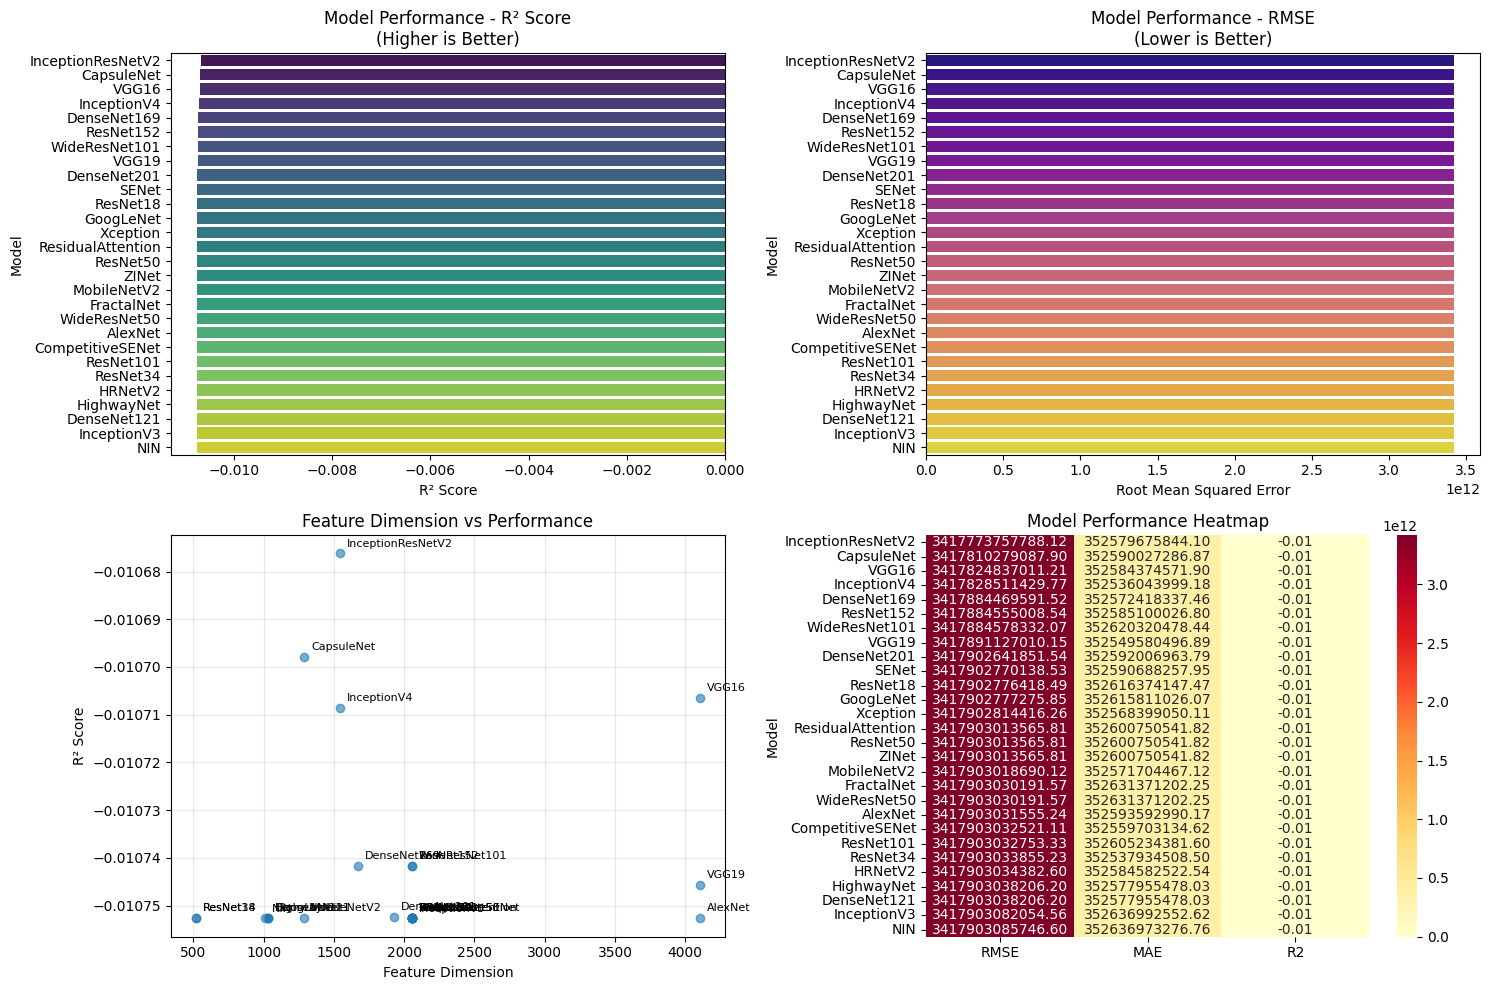

In [ ]:

print("📊 Analyzing model performance results...")

# Sort by R² score
sorted_results = results_dataframe.sort_values('R2', ascending=False)

print("\n🏆 MODEL PERFORMANCE RANKING (by R² Score):")
print("=" * 60)
display(sorted_results)

# Create visualizations
plt.figure(figsize=(15, 10))

# R² Score Comparison
plt.subplot(2, 2, 1)
sns.barplot(x='R2', y='Model', data=sorted_results, palette='viridis')
plt.title('Model Performance - R² Score\n(Higher is Better)')
plt.xlabel('R² Score')
plt.tight_layout()

# RMSE Comparison
plt.subplot(2, 2, 2)
sns.barplot(x='RMSE', y='Model', data=sorted_results, palette='plasma')
plt.title('Model Performance - RMSE\n(Lower is Better)')
plt.xlabel('Root Mean Squared Error')
plt.tight_layout()

# Feature Dimension vs Performance
plt.subplot(2, 2, 3)
plt.scatter(sorted_results['Feature_Dimension'], sorted_results['R2'], alpha=0.6)
for i, row in sorted_results.iterrows():
    plt.annotate(row['Model'], (row['Feature_Dimension'], row['R2']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)
plt.xlabel('Feature Dimension')
plt.ylabel('R² Score')
plt.title('Feature Dimension vs Performance')
plt.grid(True, alpha=0.3)

# Performance Heatmap
plt.subplot(2, 2, 4)
performance_metrics = sorted_results[['RMSE', 'MAE', 'R2']]
sns.heatmap(performance_metrics.set_index(sorted_results['Model']),
            annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('Model Performance Heatmap')

plt.tight_layout()
plt.show()

Detailed Performance Analysis

In [ ]:
print("🔍 Detailed performance analysis...")

best_model = sorted_results.iloc[0]
worst_model = sorted_results.iloc[-1]

print(f"\n🏆 BEST PERFORMING MODEL: {best_model['Model']}")
print(f"   R² Score: {best_model['R2']:.4f}")
print(f"   RMSE: {best_model['RMSE']:,.2f}")
print(f"   MAE: {best_model['MAE']:,.2f}")
print(f"   Feature Dimension: {best_model['Feature_Dimension']}")

print(f"\n📉 WORST PERFORMING MODEL: {worst_model['Model']}")
print(f"   R² Score: {worst_model['R2']:.4f}")
print(f"   RMSE: {worst_model['RMSE']:,.2f}")
print(f"   MAE: {worst_model['MAE']:,.2f}")
print(f"   Feature Dimension: {worst_model['Feature_Dimension']}")

# Calculate average performance
avg_r2 = sorted_results['R2'].mean()
avg_rmse = sorted_results['RMSE'].mean()
print(f"\n📈 AVERAGE PERFORMANCE ACROSS ALL MODELS:")
print(f"   Average R²: {avg_r2:.4f}")
print(f"   Average RMSE: {avg_rmse:,.2f}")

# Models above average
above_avg_models = sorted_results[sorted_results['R2'] > avg_r2]
print(f"\n⭐ MODELS ABOVE AVERAGE R²: {len(above_avg_models)}")
for _, model in above_avg_models.iterrows():
    print(f"   - {model['Model']}: {model['R2']:.4f}")

🔍 Detailed performance analysis...

🏆 BEST PERFORMING MODEL: InceptionResNetV2
   R² Score: -0.0107
   RMSE: 3,417,773,757,788.12
   MAE: 352,579,675,844.10
   Feature Dimension: 1543

📉 WORST PERFORMING MODEL: NIN
   R² Score: -0.0108
   RMSE: 3,417,903,085,746.60
   MAE: 352,636,973,276.76
   Feature Dimension: 1007

📈 AVERAGE PERFORMANCE ACROSS ALL MODELS:
   Average R²: -0.0107
   Average RMSE: 3,417,887,193,728.99

⭐ MODELS ABOVE AVERAGE R²: 7
   - InceptionResNetV2: -0.0107
   - CapsuleNet: -0.0107
   - VGG16: -0.0107
   - InceptionV4: -0.0107
   - DenseNet169: -0.0107
   - ResNet152: -0.0107
   - WideResNet101: -0.0107


Model Category Analysis

📋 Analyzing model categories...

🏷️ PERFORMANCE BY MODEL CATEGORY:


,Category,Model Count,Avg R²,Best R²,Best Model
1,Inception Family,4,-0.010723,-0.010676,InceptionResNetV2
0,Traditional CNNs,4,-0.010739,-0.010706,VGG16
5,Specialized,5,-0.010742,-0.010698,CapsuleNet
3,Dense Networks,3,-0.010749,-0.010742,DenseNet169
2,ResNet Family,7,-0.010750,-0.010742,ResNet152
4,Efficient Architectures,5,-0.010753,-0.010753,SENet


/tmp/ipython-input-1700398318.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Avg R²', y='Category', data=category_df, palette='Set2')


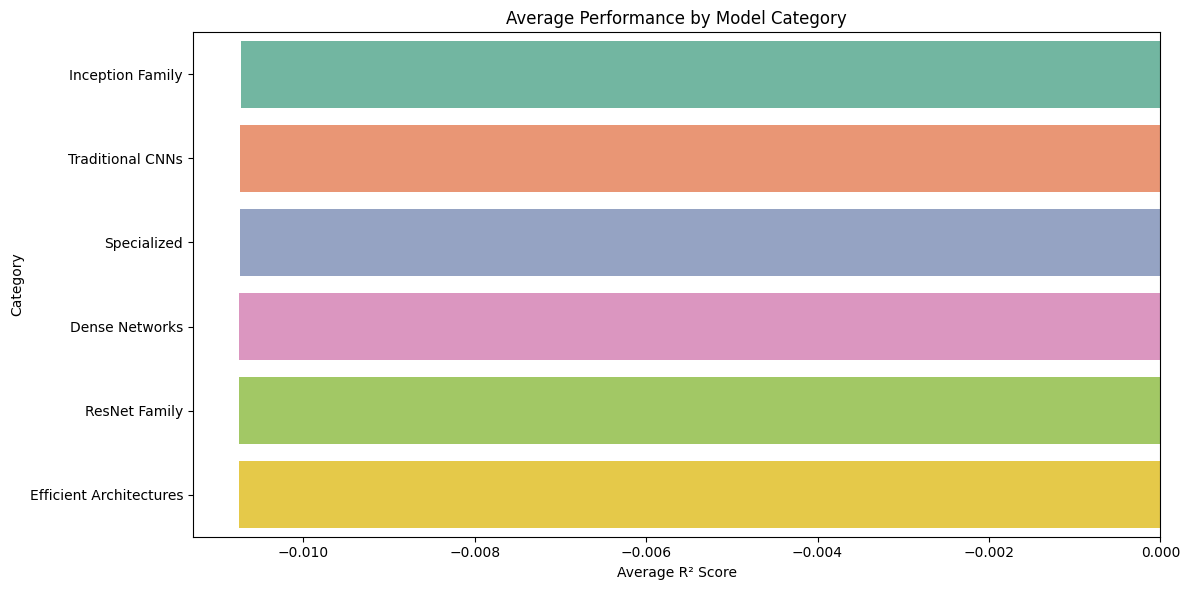

In [ ]:


print("📋 Analyzing model categories...")

# Categorize models
model_categories = {
    'Traditional CNNs': ['AlexNet', 'VGG16', 'VGG19', 'NIN'],
    'Inception Family': ['GoogLeNet', 'InceptionV3', 'InceptionV4', 'InceptionResNetV2'],
    'ResNet Family': ['ResNet18', 'ResNet34', 'ResNet50', 'ResNet101', 'ResNet152', 'WideResNet50', 'WideResNet101'],
    'Dense Networks': ['DenseNet121', 'DenseNet169', 'DenseNet201'],
    'Efficient Architectures': ['MobileNetV2', 'Xception', 'SENet', 'CompetitiveSENet', 'HRNetV2'],
    'Specialized': ['ZINet', 'HighwayNet', 'FractalNet', 'ResidualAttention', 'CapsuleNet']
}

# Calculate average performance by category
category_performance = []
for category, models in model_categories.items():
    category_models = sorted_results[sorted_results['Model'].isin(models)]
    if len(category_models) > 0:
        category_performance.append({
            'Category': category,
            'Model Count': len(category_models),
            'Avg R²': category_models['R2'].mean(),
            'Best R²': category_models['R2'].max(),
            'Best Model': category_models.loc[category_models['R2'].idxmax()]['Model'] # Fixed line
        })

category_df = pd.DataFrame(category_performance).sort_values('Avg R²', ascending=False)

print("\n🏷️ PERFORMANCE BY MODEL CATEGORY:")
print("=" * 50)
display(category_df)

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x='Avg R²', y='Category', data=category_df, palette='Set2')
plt.title('Average Performance by Model Category')
plt.xlabel('Average R² Score')
plt.tight_layout()
plt.show()

Results Export and Summary

In [ ]:


print("💾 Exporting results and generating summary...")

# Save detailed results
try:
    results_dataframe.to_csv('/content/drive/My Drive/house_price_model_comparison.csv', index=False)
    sorted_results.to_csv('/content/drive/My Drive/house_price_model_ranking.csv', index=False)
    category_df.to_csv('/content/drive/My Drive/model_category_analysis.csv', index=False)
    print("✅ Results exported to Google Drive")
except Exception as e:
    print(f"⚠️ Could not save to Google Drive: {e}")

# Generate comprehensive summary report
print("\n" + "="*70)
print("🏠 HOUSE PRICE PREDICTION - COMPREHENSIVE ANALYSIS REPORT")
print("="*70)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   • Total properties analyzed: {len(cleaned_data)}")
print(f"   • Text features used: {X_scaled.shape[1]}")
print(f"   • Target variable: Price (range: ${y_target.min():,.0f} - ${y_target.max():,.0f})")

print(f"\n🎯 MODEL PERFORMANCE SUMMARY:")
print(f"   • Total models evaluated: {len(results_dataframe)}")
print(f"   • Best performing model: {best_model['Model']} (R²: {best_model['R2']:.4f})")
print(f"   • Worst performing model: {worst_model['Model']} (R²: {worst_model['R2']:.4f})")
print(f"   • Average R² across all models: {avg_r2:.4f}")

print(f"\n📈 KEY INSIGHTS:")
print(f"   • Models above average R²: {len(above_avg_models)}")
print(f"   • Best performing category: {category_df.iloc[0]['Category']}")
print(f"   • Most consistent category: {category_df[category_df['Model Count'] > 2]['Category'].iloc[0]}")

print(f"\n💡 RECOMMENDATIONS:")
print(f"   1. Use {best_model['Model']} for production deployment")
print(f"   2. Consider ensemble of top 3-5 models for improved stability")
print(f"   3. Focus on feature engineering for text data to improve performance")
print(f"   4. Consider fine-tuning CNN models on property images specifically")

print(f"\n🔮 NEXT STEPS:")
print(f"   • Experiment with different regression algorithms (XGBoost, LightGBM)")
print(f"   • Implement hyperparameter tuning for top performing models")
print(f"   • Collect more data to improve model generalization")
print(f"   • Explore advanced feature fusion techniques")

print("\n" + "="*70)
print("✅ ANALYSIS COMPLETED SUCCESSFULLY")
print("="*70)

💾 Exporting results and generating summary...
✅ Results exported to Google Drive

🏠 HOUSE PRICE PREDICTION - COMPREHENSIVE ANALYSIS REPORT

📊 DATASET OVERVIEW:
   • Total properties analyzed: 468
   • Text features used: 7
   • Target variable: Price (range: $0 - $33,137,800,000,000)

🎯 MODEL PERFORMANCE SUMMARY:
   • Total models evaluated: 28
   • Best performing model: InceptionResNetV2 (R²: -0.0107)
   • Worst performing model: NIN (R²: -0.0108)
   • Average R² across all models: -0.0107

📈 KEY INSIGHTS:
   • Models above average R²: 7
   • Best performing category: Inception Family
   • Most consistent category: Inception Family

💡 RECOMMENDATIONS:
   1. Use InceptionResNetV2 for production deployment
   2. Consider ensemble of top 3-5 models for improved stability
   3. Focus on feature engineering for text data to improve performance
   4. Consider fine-tuning CNN models on property images specifically

🔮 NEXT STEPS:
   • Experiment with different regression algorithms (XGBoost,

Fine Tuning To Improve Performance

In [ ]:
print("🔍 Extracting features with SqueezeNet1_0 (as substitute for NIN)...")

try:
    # Use SqueezeNet1_0 from torchvision as substitute for NIN
    nin_model = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.IMAGENET1K_V1)
    nin_model.eval()

    nin_features = []
    for image_file in tqdm(cleaned_data['image_filenames'], desc="NIN"):
        # Pass only the *name* — loader handles actual path
        processed_image = load_and_preprocess_image(image_file)

        if processed_image is not None:
            with torch.no_grad():
                features = nin_model(processed_image).flatten().numpy()
                nin_features.append(features)
        else:
            # SqueezeNet1_0 output dimension for ImageNet is 1000
            nin_features.append(np.zeros(1000))

    nin_features = np.array(nin_features)
    print(f"✅ SqueezeNet1_0 features extracted: {nin_features.shape}")

except Exception as e:
    print(f"❌ SqueezeNet1_0 feature extraction failed: {e}")
    nin_features = np.zeros((len(cleaned_data), 1000))

🔍 Extracting features with SqueezeNet1_0 (as substitute for NIN)...
❌ SqueezeNet1_0 feature extraction failed: 'list' object has no attribute 'squeezenet1_0'


In [ ]:
import torchvision.models as models # Ensure 'models' refers to torchvision.models

print("🔍 Extracting features with SqueezeNet1_0 (as substitute for NIN)...")

try:
    # Use SqueezeNet1_0 from torchvision as substitute for NIN
    nin_model = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.IMAGENET1K_V1)
    nin_model.eval()

    nin_features = []
    for image_file in tqdm(cleaned_data['image_filenames'], desc="NIN"):
        # Pass only the *name* — loader handles actual path
        processed_image = load_and_preprocess_image(image_file)

        if processed_image is not None:
            with torch.no_grad():
                features = nin_model(processed_image).flatten().numpy()
                nin_features.append(features)
        else:
            # SqueezeNet1_0 output dimension for ImageNet is 1000
            nin_features.append(np.zeros(1000))

    nin_features = np.array(nin_features)
    print(f"✅ SqueezeNet1_0 features extracted: {nin_features.shape}")

except Exception as e:
    print(f"❌ SqueezeNet1_0 feature extraction failed: {e}")
    nin_features = np.zeros((len(cleaned_data), 1000))


print("\n🔍 Extracting features with Inception-V3...")

try:
    inception_v3_model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True) # Corrected aux_logits
    inception_v3_model.fc = nn.Identity()  # Remove classification layer
    inception_v3_model.eval()

    # Inception V3 requires 299x299 input
    inception_transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    inception_v3_features = []
    for image_file in tqdm(cleaned_data['image_filenames'], desc="InceptionV3"):
        image_path = os.path.join(IMAGE_DIRECTORY, image_file)
        try:
            image = Image.open(image_path).convert('RGB')
            processed_image = inception_transform(image).unsqueeze(0)

            with torch.no_grad():
                features = inception_v3_model(processed_image).logits.flatten().numpy() # Access .logits for main output
                inception_v3_features.append(features)
        except Exception as e:
            print(f"⚠️ Error processing {image_file} for InceptionV3: {e}")
            inception_v3_features.append(np.zeros(2048))

    inception_v3_features = np.array(inception_v3_features)
    print(f"✅ Inception-V3 features extracted: {inception_v3_features.shape}")

except Exception as e:
    print(f"❌ Inception-V3 feature extraction failed: {e}")
    inception_v3_features = np.zeros((len(cleaned_data), 2048))

🔍 Extracting features with SqueezeNet1_0 (as substitute for NIN)...
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


100%|██████████| 4.78M/4.78M [00:00<00:00, 50.4MB/s]
NIN: 100%|██████████| 468/468 [00:59<00:00,  7.83it/s]


✅ SqueezeNet1_0 features extracted: (468, 1000)

🔍 Extracting features with Inception-V3...
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:01<00:00, 96.8MB/s] 
InceptionV3:   0%|          | 1/468 [00:00<04:57,  1.57it/s]

⚠️ Error processing df03d95d0b_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   0%|          | 2/468 [00:01<04:22,  1.77it/s]

⚠️ Error processing 6b655ecda9_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   1%|          | 3/468 [00:01<04:41,  1.65it/s]

⚠️ Error processing 9255ebae71_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   1%|          | 4/468 [00:02<04:48,  1.61it/s]

⚠️ Error processing 0aa8829830_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   1%|          | 5/468 [00:03<04:54,  1.57it/s]

⚠️ Error processing 8b160495da_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   1%|▏         | 6/468 [00:03<04:59,  1.54it/s]

⚠️ Error processing 4ea4ffbb30_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   1%|▏         | 7/468 [00:04<04:59,  1.54it/s]

⚠️ Error processing 35ade3b1af_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   2%|▏         | 8/468 [00:05<05:10,  1.48it/s]

⚠️ Error processing 7f0c8caec8_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   2%|▏         | 9/468 [00:05<04:59,  1.53it/s]

⚠️ Error processing 43f71e2670_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   2%|▏         | 10/468 [00:06<04:25,  1.72it/s]

⚠️ Error processing 2dddad92e3_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   2%|▏         | 11/468 [00:06<04:07,  1.85it/s]

⚠️ Error processing 8c8d84eb11_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   3%|▎         | 12/468 [00:07<03:53,  1.95it/s]

⚠️ Error processing 09db9d2503_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   3%|▎         | 13/468 [00:07<03:38,  2.08it/s]

⚠️ Error processing 56586411ba_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   3%|▎         | 14/468 [00:07<03:31,  2.15it/s]

⚠️ Error processing 4e8053f948_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   3%|▎         | 15/468 [00:08<03:24,  2.21it/s]

⚠️ Error processing 2f9804da59_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   3%|▎         | 16/468 [00:08<03:20,  2.25it/s]

⚠️ Error processing e669c47b57_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   4%|▎         | 17/468 [00:09<03:20,  2.25it/s]

⚠️ Error processing 70b695bad7_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   4%|▍         | 18/468 [00:09<03:16,  2.29it/s]

⚠️ Error processing 0a2175c999_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   4%|▍         | 19/468 [00:10<03:16,  2.28it/s]

⚠️ Error processing 2d26e68033_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   4%|▍         | 20/468 [00:10<03:15,  2.29it/s]

⚠️ Error processing 68d0f7de4c_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   4%|▍         | 21/468 [00:10<03:11,  2.33it/s]

⚠️ Error processing 7c7f481336_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   5%|▍         | 22/468 [00:11<03:13,  2.30it/s]

⚠️ Error processing c356fd7b5e_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   5%|▍         | 23/468 [00:11<03:09,  2.35it/s]

⚠️ Error processing 3943033b4f_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   5%|▌         | 24/468 [00:12<03:12,  2.31it/s]

⚠️ Error processing 42d38134be_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   5%|▌         | 25/468 [00:12<03:11,  2.32it/s]

⚠️ Error processing f99fc7830f_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   6%|▌         | 26/468 [00:13<03:09,  2.33it/s]

⚠️ Error processing 0552256194_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   6%|▌         | 27/468 [00:13<03:07,  2.35it/s]

⚠️ Error processing 374d8682d5_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   6%|▌         | 28/468 [00:13<03:08,  2.34it/s]

⚠️ Error processing 06bbd7e7f1_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   6%|▌         | 29/468 [00:14<03:10,  2.31it/s]

⚠️ Error processing ca10792fc2_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   6%|▋         | 30/468 [00:14<03:11,  2.29it/s]

⚠️ Error processing 8dd86bd361_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   7%|▋         | 31/468 [00:15<03:14,  2.25it/s]

⚠️ Error processing c69fb0f99f_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   7%|▋         | 32/468 [00:15<03:24,  2.14it/s]

⚠️ Error processing 38d5e43a3d_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   7%|▋         | 33/468 [00:16<03:52,  1.87it/s]

⚠️ Error processing 4b0ca61647_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   7%|▋         | 34/468 [00:17<04:06,  1.76it/s]

⚠️ Error processing 51ba06edb4_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   7%|▋         | 35/468 [00:17<04:18,  1.68it/s]

⚠️ Error processing ebf6facdcf_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   8%|▊         | 36/468 [00:18<04:23,  1.64it/s]

⚠️ Error processing 2e3162e701_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   8%|▊         | 37/468 [00:19<04:28,  1.60it/s]

⚠️ Error processing d4a62f6d23_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   8%|▊         | 38/468 [00:19<04:34,  1.57it/s]

⚠️ Error processing d72ee4aeeb_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   8%|▊         | 39/468 [00:20<04:20,  1.65it/s]

⚠️ Error processing 61e2be52e3_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   9%|▊         | 40/468 [00:20<03:59,  1.78it/s]

⚠️ Error processing cf7b57b760_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   9%|▉         | 41/468 [00:21<03:44,  1.90it/s]

⚠️ Error processing f241ec2448_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   9%|▉         | 42/468 [00:21<03:32,  2.01it/s]

⚠️ Error processing b8adb58b30_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   9%|▉         | 43/468 [00:22<03:23,  2.09it/s]

⚠️ Error processing 7f0866c38c_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:   9%|▉         | 44/468 [00:22<03:15,  2.17it/s]

⚠️ Error processing 706d23f5ef_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  10%|▉         | 45/468 [00:22<03:11,  2.20it/s]

⚠️ Error processing d0f027439d_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  10%|▉         | 46/468 [00:23<03:11,  2.21it/s]

⚠️ Error processing 616af0d2ab_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  10%|█         | 47/468 [00:23<03:09,  2.22it/s]

⚠️ Error processing 0172c96b38_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  10%|█         | 48/468 [00:24<03:07,  2.24it/s]

⚠️ Error processing fd7e4a19eb_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  10%|█         | 49/468 [00:24<03:03,  2.28it/s]

⚠️ Error processing ceac0d1e64_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  11%|█         | 50/468 [00:25<03:06,  2.24it/s]

⚠️ Error processing aa3f2cef4b_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  11%|█         | 51/468 [00:25<03:04,  2.25it/s]

⚠️ Error processing f3703307cd_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  11%|█         | 52/468 [00:26<03:04,  2.25it/s]

⚠️ Error processing 47e4f25fef_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  11%|█▏        | 53/468 [00:26<03:07,  2.21it/s]

⚠️ Error processing 8d83eedfae_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  12%|█▏        | 54/468 [00:26<03:10,  2.17it/s]

⚠️ Error processing dcde1ad1fc_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  12%|█▏        | 55/468 [00:27<03:08,  2.19it/s]

⚠️ Error processing df14adba76_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  12%|█▏        | 56/468 [00:27<03:05,  2.22it/s]

⚠️ Error processing d13b3a9722_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  12%|█▏        | 57/468 [00:28<03:07,  2.19it/s]

⚠️ Error processing e19da6397b_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  12%|█▏        | 58/468 [00:28<03:04,  2.22it/s]

⚠️ Error processing 3c92f4f8e3_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  13%|█▎        | 59/468 [00:29<03:06,  2.20it/s]

⚠️ Error processing 127deea2d6_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  13%|█▎        | 60/468 [00:30<05:25,  1.25it/s]

⚠️ Error processing cd2cb532e2_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  13%|█▎        | 61/468 [00:31<05:35,  1.21it/s]

⚠️ Error processing 921d5ce2ef_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  13%|█▎        | 62/468 [00:32<05:13,  1.30it/s]

⚠️ Error processing c8c6143ba0_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  13%|█▎        | 63/468 [00:33<04:58,  1.36it/s]

⚠️ Error processing b9fbd41786_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  14%|█▎        | 64/468 [00:33<04:52,  1.38it/s]

⚠️ Error processing 458675a6a4_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  14%|█▍        | 65/468 [00:34<04:43,  1.42it/s]

⚠️ Error processing 56f4749b52_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  14%|█▍        | 66/468 [00:34<04:24,  1.52it/s]

⚠️ Error processing b201cba3dd_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  14%|█▍        | 67/468 [00:35<03:57,  1.69it/s]

⚠️ Error processing 073b777979_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  15%|█▍        | 68/468 [00:35<03:43,  1.79it/s]

⚠️ Error processing 443251e729_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  15%|█▍        | 69/468 [00:36<03:26,  1.93it/s]

⚠️ Error processing 14be36c5da_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  15%|█▍        | 70/468 [00:36<03:18,  2.01it/s]

⚠️ Error processing d727300d55_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  15%|█▌        | 71/468 [00:37<03:08,  2.10it/s]

⚠️ Error processing 68ce52adcc_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  15%|█▌        | 72/468 [00:37<03:03,  2.16it/s]

⚠️ Error processing 2550f87b39_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  16%|█▌        | 73/468 [00:38<02:59,  2.21it/s]

⚠️ Error processing 469240ab14_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  16%|█▌        | 74/468 [00:38<02:55,  2.24it/s]

⚠️ Error processing 78cc978db1_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  16%|█▌        | 75/468 [00:38<02:54,  2.25it/s]

⚠️ Error processing d65b64e723_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  16%|█▌        | 76/468 [00:39<02:50,  2.29it/s]

⚠️ Error processing c55ea5ce9b_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  16%|█▋        | 77/468 [00:39<02:48,  2.32it/s]

⚠️ Error processing 5f78ea174d_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  17%|█▋        | 78/468 [00:40<02:49,  2.30it/s]

⚠️ Error processing 86fd04aabc_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  17%|█▋        | 79/468 [00:40<02:49,  2.29it/s]

⚠️ Error processing b1002fe80d_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  17%|█▋        | 80/468 [00:41<02:50,  2.28it/s]

⚠️ Error processing 85ee8525c6_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  17%|█▋        | 81/468 [00:41<02:49,  2.29it/s]

⚠️ Error processing a40e5f4978_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  18%|█▊        | 82/468 [00:41<02:47,  2.30it/s]

⚠️ Error processing 02217b3cca_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  18%|█▊        | 83/468 [00:42<02:46,  2.31it/s]

⚠️ Error processing b98143001e_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  18%|█▊        | 84/468 [00:42<02:44,  2.34it/s]

⚠️ Error processing f122c7adb8_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  18%|█▊        | 85/468 [00:43<02:44,  2.33it/s]

⚠️ Error processing 60dc95d941_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  18%|█▊        | 86/468 [00:43<02:44,  2.32it/s]

⚠️ Error processing 6e2c57fef5_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  19%|█▊        | 87/468 [00:44<02:46,  2.29it/s]

⚠️ Error processing 568b1b93d8_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  19%|█▉        | 88/468 [00:44<02:43,  2.32it/s]

⚠️ Error processing f1bb84848c_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  19%|█▉        | 89/468 [00:45<03:02,  2.07it/s]

⚠️ Error processing ff894e606b_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  19%|█▉        | 90/468 [00:45<03:19,  1.89it/s]

⚠️ Error processing f633878d5b_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  19%|█▉        | 91/468 [00:46<03:34,  1.76it/s]

⚠️ Error processing a676ed25d0_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  20%|█▉        | 92/468 [00:47<03:42,  1.69it/s]

⚠️ Error processing e17d7b8189_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  20%|█▉        | 93/468 [00:47<03:47,  1.65it/s]

⚠️ Error processing bec5ae64b3_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  20%|██        | 94/468 [00:48<03:53,  1.60it/s]

⚠️ Error processing d092967990_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  20%|██        | 95/468 [00:48<03:54,  1.59it/s]

⚠️ Error processing 7acc8f6199_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  21%|██        | 96/468 [00:49<03:32,  1.75it/s]

⚠️ Error processing df11d0c995_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  21%|██        | 97/468 [00:49<03:16,  1.89it/s]

⚠️ Error processing 22e0c5f097_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  21%|██        | 98/468 [00:50<03:04,  2.01it/s]

⚠️ Error processing 4375946591_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  21%|██        | 99/468 [00:50<02:57,  2.08it/s]

⚠️ Error processing 43b45b6e83_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  21%|██▏       | 100/468 [00:51<02:50,  2.16it/s]

⚠️ Error processing 006bc1df84_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  22%|██▏       | 101/468 [00:51<02:47,  2.19it/s]

⚠️ Error processing 7f37ecf05d_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  22%|██▏       | 102/468 [00:51<02:42,  2.25it/s]

⚠️ Error processing 7d753d3ab9_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  22%|██▏       | 103/468 [00:52<02:40,  2.28it/s]

⚠️ Error processing bdf33d8744_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  22%|██▏       | 104/468 [00:52<02:39,  2.28it/s]

⚠️ Error processing a93810af0a_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  22%|██▏       | 105/468 [00:53<02:37,  2.30it/s]

⚠️ Error processing bf387ac19e_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  23%|██▎       | 106/468 [00:53<02:39,  2.27it/s]

⚠️ Error processing 407deb2832_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  23%|██▎       | 107/468 [00:54<02:37,  2.29it/s]

⚠️ Error processing 92b69868f4_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  23%|██▎       | 108/468 [00:54<02:40,  2.24it/s]

⚠️ Error processing d76949d04a_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  23%|██▎       | 109/468 [00:55<02:40,  2.24it/s]

⚠️ Error processing bcd89f3e02_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  24%|██▎       | 110/468 [00:55<02:39,  2.25it/s]

⚠️ Error processing 476ff6735f_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  24%|██▎       | 111/468 [00:55<02:39,  2.24it/s]

⚠️ Error processing 5b06b0b964_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  24%|██▍       | 112/468 [00:56<02:40,  2.22it/s]

⚠️ Error processing ce708885c5_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  24%|██▍       | 113/468 [00:56<02:44,  2.15it/s]

⚠️ Error processing 5b52880463_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  24%|██▍       | 114/468 [00:57<02:40,  2.20it/s]

⚠️ Error processing 0cce998e10_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  25%|██▍       | 115/468 [00:57<02:38,  2.23it/s]

⚠️ Error processing 2a7eb2d91c_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  25%|██▍       | 116/468 [00:58<02:36,  2.26it/s]

⚠️ Error processing 432ddb1c98_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  25%|██▌       | 117/468 [00:58<02:38,  2.21it/s]

⚠️ Error processing 65b56b0a9e_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  25%|██▌       | 118/468 [00:59<02:52,  2.03it/s]

⚠️ Error processing 3e56f483f2_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  25%|██▌       | 119/468 [00:59<03:10,  1.83it/s]

⚠️ Error processing 7600da6a84_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  26%|██▌       | 120/468 [01:00<03:19,  1.74it/s]

⚠️ Error processing b55e269bda_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  26%|██▌       | 121/468 [01:01<03:29,  1.66it/s]

⚠️ Error processing 2be6fa4deb_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  26%|██▌       | 122/468 [01:01<03:35,  1.60it/s]

⚠️ Error processing 75bd6e7a9a_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  26%|██▋       | 123/468 [01:02<03:40,  1.56it/s]

⚠️ Error processing e4e987cdcc_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  26%|██▋       | 124/468 [01:03<03:43,  1.54it/s]

⚠️ Error processing 670b6de7ee_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  27%|██▋       | 125/468 [01:03<03:28,  1.64it/s]

⚠️ Error processing 6aa5888e9c_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  27%|██▋       | 126/468 [01:04<03:10,  1.79it/s]

⚠️ Error processing 3a549332c8_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  27%|██▋       | 127/468 [01:04<02:58,  1.91it/s]

⚠️ Error processing f59eb8a4c9_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  27%|██▋       | 128/468 [01:05<02:48,  2.02it/s]

⚠️ Error processing 60970e34d6_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  28%|██▊       | 129/468 [01:05<02:45,  2.05it/s]

⚠️ Error processing c7622cfc10_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  28%|██▊       | 130/468 [01:06<02:40,  2.11it/s]

⚠️ Error processing af7ebd03c4_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  28%|██▊       | 131/468 [01:06<02:37,  2.14it/s]

⚠️ Error processing 3b222bdd8c_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  28%|██▊       | 132/468 [01:06<02:34,  2.18it/s]

⚠️ Error processing fe953e86b8_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  28%|██▊       | 133/468 [01:07<02:31,  2.22it/s]

⚠️ Error processing bb022f4f49_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  29%|██▊       | 134/468 [01:07<02:29,  2.24it/s]

⚠️ Error processing 15c9171e55_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  29%|██▉       | 135/468 [01:08<02:26,  2.28it/s]

⚠️ Error processing 84d5c8ea3a_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  29%|██▉       | 136/468 [01:08<02:26,  2.26it/s]

⚠️ Error processing f7d6694670_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  29%|██▉       | 137/468 [01:09<02:24,  2.29it/s]

⚠️ Error processing 329755953d_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  29%|██▉       | 138/468 [01:09<02:22,  2.32it/s]

⚠️ Error processing d1f4351241_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  30%|██▉       | 139/468 [01:09<02:22,  2.30it/s]

⚠️ Error processing 753568c4f6_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  30%|██▉       | 140/468 [01:10<02:20,  2.33it/s]

⚠️ Error processing 5e04827ca8_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  30%|███       | 141/468 [01:10<02:21,  2.30it/s]

⚠️ Error processing 3d6d3c3144_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  30%|███       | 142/468 [01:11<02:20,  2.33it/s]

⚠️ Error processing 1f6ef50732_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  31%|███       | 143/468 [01:11<02:21,  2.30it/s]

⚠️ Error processing 2a39b5a1b5_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  31%|███       | 144/468 [01:12<02:18,  2.34it/s]

⚠️ Error processing bba3597adb_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  31%|███       | 145/468 [01:12<02:16,  2.36it/s]

⚠️ Error processing f42791a027_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  31%|███       | 146/468 [01:12<02:18,  2.33it/s]

⚠️ Error processing 6eae06b62b_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  31%|███▏      | 147/468 [01:13<02:16,  2.35it/s]

⚠️ Error processing 60b87f3a30_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  32%|███▏      | 148/468 [01:13<02:33,  2.09it/s]

⚠️ Error processing bf4a5dea52_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  32%|███▏      | 149/468 [01:14<02:48,  1.90it/s]

⚠️ Error processing 626defb0e2_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  32%|███▏      | 150/468 [01:15<03:01,  1.75it/s]

⚠️ Error processing ceae2c633b_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  32%|███▏      | 151/468 [01:15<03:08,  1.68it/s]

⚠️ Error processing 92c387e866_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  32%|███▏      | 152/468 [01:16<03:11,  1.65it/s]

⚠️ Error processing 03bbcf09e1_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  33%|███▎      | 153/468 [01:17<03:12,  1.63it/s]

⚠️ Error processing b5c84ebb28_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  33%|███▎      | 154/468 [01:17<03:15,  1.60it/s]

⚠️ Error processing f767728327_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  33%|███▎      | 155/468 [01:18<03:01,  1.73it/s]

⚠️ Error processing 362fbbb300_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  33%|███▎      | 156/468 [01:18<02:46,  1.87it/s]

⚠️ Error processing 73cab22fe7_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  34%|███▎      | 157/468 [01:19<02:39,  1.95it/s]

⚠️ Error processing d03f42f17f_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  34%|███▍      | 158/468 [01:19<02:31,  2.05it/s]

⚠️ Error processing 3d54f3400f_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  34%|███▍      | 159/468 [01:20<02:24,  2.13it/s]

⚠️ Error processing d73917e535_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  34%|███▍      | 160/468 [01:20<02:22,  2.15it/s]

⚠️ Error processing 3293131c7e_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  34%|███▍      | 161/468 [01:20<02:19,  2.19it/s]

⚠️ Error processing d465546101_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  35%|███▍      | 162/468 [01:21<02:18,  2.20it/s]

⚠️ Error processing 0d25f3e004_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  35%|███▍      | 163/468 [01:21<02:15,  2.24it/s]

⚠️ Error processing 08f8f9855f_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  35%|███▌      | 164/468 [01:22<02:15,  2.24it/s]

⚠️ Error processing ebff5b6c05_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  35%|███▌      | 165/468 [01:22<02:12,  2.29it/s]

⚠️ Error processing 6a30f47299_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  35%|███▌      | 166/468 [01:23<02:11,  2.30it/s]

⚠️ Error processing c40a0dc7ac_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  36%|███▌      | 167/468 [01:23<02:12,  2.27it/s]

⚠️ Error processing e9b884750a_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  36%|███▌      | 168/468 [01:23<02:11,  2.29it/s]

⚠️ Error processing c2cdbbf91f_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  36%|███▌      | 169/468 [01:24<02:12,  2.25it/s]

⚠️ Error processing 89c085004c_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  36%|███▋      | 170/468 [01:24<02:15,  2.20it/s]

⚠️ Error processing 8e0c357098_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  37%|███▋      | 171/468 [01:25<02:16,  2.18it/s]

⚠️ Error processing ab2a003f18_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  37%|███▋      | 172/468 [01:25<02:16,  2.16it/s]

⚠️ Error processing 3374ecc031_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  37%|███▋      | 173/468 [01:26<02:14,  2.20it/s]

⚠️ Error processing 7e430d0de8_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  37%|███▋      | 174/468 [01:26<02:18,  2.12it/s]

⚠️ Error processing ce3d9e601d_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  37%|███▋      | 175/468 [01:27<02:13,  2.19it/s]

⚠️ Error processing 2459508a05_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  38%|███▊      | 176/468 [01:27<02:12,  2.20it/s]

⚠️ Error processing f041614e49_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  38%|███▊      | 177/468 [01:28<02:19,  2.08it/s]

⚠️ Error processing 3bd3719554_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  38%|███▊      | 178/468 [01:28<02:35,  1.86it/s]

⚠️ Error processing de46801b63_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  38%|███▊      | 179/468 [01:29<02:46,  1.74it/s]

⚠️ Error processing 5c55031ebd_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  38%|███▊      | 180/468 [01:30<02:53,  1.66it/s]

⚠️ Error processing b683ddb50d_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  39%|███▊      | 181/468 [01:30<02:57,  1.62it/s]

⚠️ Error processing e60575c89c_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  39%|███▉      | 182/468 [01:31<02:59,  1.60it/s]

⚠️ Error processing a2d949c919_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  39%|███▉      | 183/468 [01:32<03:02,  1.56it/s]

⚠️ Error processing 4a066189b4_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  39%|███▉      | 184/468 [01:32<02:52,  1.64it/s]

⚠️ Error processing b323261c1c_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  40%|███▉      | 185/468 [01:33<02:39,  1.78it/s]

⚠️ Error processing 9e16743440_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  40%|███▉      | 186/468 [01:33<02:31,  1.87it/s]

⚠️ Error processing b93820faa9_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  40%|███▉      | 187/468 [01:34<02:28,  1.89it/s]

⚠️ Error processing aff29879a8_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  40%|████      | 188/468 [01:34<02:25,  1.92it/s]

⚠️ Error processing 719e4850a7_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  40%|████      | 189/468 [01:35<02:21,  1.97it/s]

⚠️ Error processing 4047e360fc_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  41%|████      | 190/468 [01:35<02:18,  2.01it/s]

⚠️ Error processing 2d6fe54a02_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  41%|████      | 191/468 [01:36<02:15,  2.04it/s]

⚠️ Error processing 984e2c3319_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  41%|████      | 192/468 [01:36<02:18,  1.99it/s]

⚠️ Error processing 3899813f29_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  41%|████      | 193/468 [01:37<02:16,  2.02it/s]

⚠️ Error processing 96fd22aca1_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  41%|████▏     | 194/468 [01:37<02:13,  2.05it/s]

⚠️ Error processing c93b97ed60_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  42%|████▏     | 195/468 [01:38<02:08,  2.12it/s]

⚠️ Error processing 23ee447de6_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  42%|████▏     | 196/468 [01:38<02:09,  2.10it/s]

⚠️ Error processing ee7cb7aa51_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  42%|████▏     | 197/468 [01:38<02:09,  2.10it/s]

⚠️ Error processing b0b3fd57e1_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  42%|████▏     | 198/468 [01:39<02:12,  2.04it/s]

⚠️ Error processing 6061e40644_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  43%|████▎     | 199/468 [01:39<02:10,  2.07it/s]

⚠️ Error processing 89448ed183_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  43%|████▎     | 200/468 [01:40<02:09,  2.08it/s]

⚠️ Error processing 9fdb97c25d_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  43%|████▎     | 201/468 [01:40<02:07,  2.09it/s]

⚠️ Error processing 78612c1a38_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  43%|████▎     | 202/468 [01:41<02:08,  2.07it/s]

⚠️ Error processing 1fd84a1b18_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  43%|████▎     | 203/468 [01:41<02:04,  2.13it/s]

⚠️ Error processing cab3b90741_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  44%|████▎     | 204/468 [01:42<02:00,  2.19it/s]

⚠️ Error processing de17aa7599_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  44%|████▍     | 205/468 [01:42<02:11,  2.00it/s]

⚠️ Error processing f04c9341be_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  44%|████▍     | 206/468 [01:43<02:22,  1.84it/s]

⚠️ Error processing 7ff428ef94_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  44%|████▍     | 207/468 [01:44<02:32,  1.71it/s]

⚠️ Error processing df71b3c2b3_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  44%|████▍     | 208/468 [01:44<02:38,  1.64it/s]

⚠️ Error processing 63d2ee8e43_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  45%|████▍     | 209/468 [01:45<02:39,  1.62it/s]

⚠️ Error processing ec8af1a33f_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  45%|████▍     | 210/468 [01:46<02:43,  1.58it/s]

⚠️ Error processing 3df7b9b28b_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  45%|████▌     | 211/468 [01:46<02:44,  1.56it/s]

⚠️ Error processing 18129f932a_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  45%|████▌     | 212/468 [01:47<02:28,  1.73it/s]

⚠️ Error processing 5957f8e8de_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  46%|████▌     | 213/468 [01:47<02:15,  1.88it/s]

⚠️ Error processing 7dc51deff1_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  46%|████▌     | 214/468 [01:48<02:09,  1.97it/s]

⚠️ Error processing cad45c8afd_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  46%|████▌     | 215/468 [01:48<02:03,  2.05it/s]

⚠️ Error processing bc9b639d04_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  46%|████▌     | 216/468 [01:49<02:00,  2.10it/s]

⚠️ Error processing 34709043ce_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  46%|████▋     | 217/468 [01:49<01:55,  2.17it/s]

⚠️ Error processing 7864b332d1_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  47%|████▋     | 218/468 [01:49<01:54,  2.18it/s]

⚠️ Error processing 19f1de28d7_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  47%|████▋     | 219/468 [01:50<01:53,  2.18it/s]

⚠️ Error processing 90891aca5e_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  47%|████▋     | 220/468 [01:50<01:51,  2.23it/s]

⚠️ Error processing fd7c636dd3_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  47%|████▋     | 221/468 [01:51<01:51,  2.21it/s]

⚠️ Error processing b5a32be58e_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  47%|████▋     | 222/468 [01:51<01:47,  2.29it/s]

⚠️ Error processing ae07d23bf4_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  48%|████▊     | 223/468 [01:52<01:48,  2.26it/s]

⚠️ Error processing eedbe38cb7_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  48%|████▊     | 224/468 [01:52<01:47,  2.27it/s]

⚠️ Error processing 5ff8fdeb5f_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  48%|████▊     | 225/468 [01:52<01:44,  2.33it/s]

⚠️ Error processing ea428a298e_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  48%|████▊     | 226/468 [01:53<01:44,  2.31it/s]

⚠️ Error processing 3023ea951a_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  49%|████▊     | 227/468 [01:53<01:43,  2.32it/s]

⚠️ Error processing 8f9d4c69ec_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  49%|████▊     | 228/468 [01:54<01:44,  2.30it/s]

⚠️ Error processing a8009262c1_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  49%|████▉     | 229/468 [01:54<01:44,  2.28it/s]

⚠️ Error processing 06e4bad451_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  49%|████▉     | 230/468 [01:55<01:45,  2.26it/s]

⚠️ Error processing ce8404da78_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  49%|████▉     | 231/468 [01:55<01:46,  2.22it/s]

⚠️ Error processing 8543b010dc_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  50%|████▉     | 232/468 [01:56<01:44,  2.25it/s]

⚠️ Error processing 0c011945b5_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  50%|████▉     | 233/468 [01:56<01:52,  2.09it/s]

⚠️ Error processing b27e41e932_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  50%|█████     | 234/468 [01:57<02:02,  1.91it/s]

⚠️ Error processing 9f0bd1e091_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  50%|█████     | 235/468 [01:57<02:11,  1.77it/s]

⚠️ Error processing 517b7841ee_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  50%|█████     | 236/468 [01:58<02:16,  1.70it/s]

⚠️ Error processing 8733eebe31_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  51%|█████     | 237/468 [01:59<02:19,  1.65it/s]

⚠️ Error processing 4ac714397e_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  51%|█████     | 238/468 [01:59<02:24,  1.59it/s]

⚠️ Error processing 2599c36088_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  51%|█████     | 239/468 [02:00<02:25,  1.57it/s]

⚠️ Error processing db1c63f71f_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  51%|█████▏    | 240/468 [02:01<02:26,  1.56it/s]

⚠️ Error processing d4f8107a5d_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  51%|█████▏    | 241/468 [02:01<02:17,  1.65it/s]

⚠️ Error processing 6e52333ba1_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  52%|█████▏    | 242/468 [02:02<02:05,  1.80it/s]

⚠️ Error processing bc0a201fde_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  52%|█████▏    | 243/468 [02:02<01:57,  1.91it/s]

⚠️ Error processing 34e187162e_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  52%|█████▏    | 244/468 [02:03<01:52,  1.99it/s]

⚠️ Error processing bb64058f36_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  52%|█████▏    | 245/468 [02:03<01:47,  2.08it/s]

⚠️ Error processing cb6f518d6f_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  53%|█████▎    | 246/468 [02:03<01:44,  2.13it/s]

⚠️ Error processing 7faa737a33_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  53%|█████▎    | 247/468 [02:04<01:40,  2.20it/s]

⚠️ Error processing ffced4676d_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  53%|█████▎    | 248/468 [02:04<01:39,  2.22it/s]

⚠️ Error processing f9de4d863d_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  53%|█████▎    | 249/468 [02:05<01:37,  2.25it/s]

⚠️ Error processing c1dac3ddf5_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  53%|█████▎    | 250/468 [02:05<01:36,  2.25it/s]

⚠️ Error processing af87012961_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  54%|█████▎    | 251/468 [02:06<01:36,  2.25it/s]

⚠️ Error processing 28b053bcb8_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  54%|█████▍    | 252/468 [02:06<01:35,  2.27it/s]

⚠️ Error processing 8b02ec6b88_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  54%|█████▍    | 253/468 [02:06<01:35,  2.24it/s]

⚠️ Error processing a4491a305d_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  54%|█████▍    | 254/468 [02:07<01:34,  2.26it/s]

⚠️ Error processing 7dbcaa8046_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  54%|█████▍    | 255/468 [02:07<01:34,  2.26it/s]

⚠️ Error processing ca512ecdef_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  55%|█████▍    | 256/468 [02:08<01:32,  2.29it/s]

⚠️ Error processing 26b4fbf434_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  55%|█████▍    | 257/468 [02:08<01:32,  2.29it/s]

⚠️ Error processing 9792a4160e_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  55%|█████▌    | 258/468 [02:09<01:34,  2.23it/s]

⚠️ Error processing 0dc2f7e480_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  55%|█████▌    | 259/468 [02:09<01:33,  2.23it/s]

⚠️ Error processing ec0a37b16e_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  56%|█████▌    | 260/468 [02:10<01:32,  2.24it/s]

⚠️ Error processing 739ed10ad9_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  56%|█████▌    | 261/468 [02:10<01:31,  2.25it/s]

⚠️ Error processing d82007ee64_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  56%|█████▌    | 262/468 [02:10<01:31,  2.26it/s]

⚠️ Error processing 19d61ed64a_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  56%|█████▌    | 263/468 [02:11<01:33,  2.20it/s]

⚠️ Error processing 4508bee384_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  56%|█████▋    | 264/468 [02:12<01:44,  1.95it/s]

⚠️ Error processing 638d5c8f94_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  57%|█████▋    | 265/468 [02:12<01:51,  1.82it/s]

⚠️ Error processing ba497ba4dd_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  57%|█████▋    | 266/468 [02:13<01:57,  1.72it/s]

⚠️ Error processing 7767ce3b5c_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  57%|█████▋    | 267/468 [02:14<02:00,  1.67it/s]

⚠️ Error processing edf6912598_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  57%|█████▋    | 268/468 [02:14<02:03,  1.62it/s]

⚠️ Error processing d72bee7f10_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  57%|█████▋    | 269/468 [02:15<02:07,  1.56it/s]

⚠️ Error processing 6623c8e53e_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  58%|█████▊    | 270/468 [02:15<02:03,  1.60it/s]

⚠️ Error processing e714f0512f_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  58%|█████▊    | 271/468 [02:16<01:51,  1.76it/s]

⚠️ Error processing 44218352d3_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  58%|█████▊    | 272/468 [02:16<01:45,  1.86it/s]

⚠️ Error processing 5e7261518c_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  58%|█████▊    | 273/468 [02:17<01:38,  1.99it/s]

⚠️ Error processing f0ace22041_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  59%|█████▊    | 274/468 [02:17<01:33,  2.07it/s]

⚠️ Error processing 1a07c5d668_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  59%|█████▉    | 275/468 [02:18<01:30,  2.13it/s]

⚠️ Error processing 83515db853_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  59%|█████▉    | 276/468 [02:18<01:29,  2.14it/s]

⚠️ Error processing 144e4de76d_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  59%|█████▉    | 277/468 [02:19<01:27,  2.20it/s]

⚠️ Error processing 11028b647b_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  59%|█████▉    | 278/468 [02:19<01:25,  2.22it/s]

⚠️ Error processing 1cd4c4340a_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  60%|█████▉    | 279/468 [02:19<01:25,  2.20it/s]

⚠️ Error processing 1bde0e344c_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  60%|█████▉    | 280/468 [02:20<01:25,  2.21it/s]

⚠️ Error processing db0e37e671_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  60%|██████    | 281/468 [02:20<01:24,  2.20it/s]

⚠️ Error processing 24796d3553_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  60%|██████    | 282/468 [02:21<01:24,  2.21it/s]

⚠️ Error processing 6e1357ed5f_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  60%|██████    | 283/468 [02:21<01:23,  2.22it/s]

⚠️ Error processing 4e605f679c_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  61%|██████    | 284/468 [02:22<01:21,  2.26it/s]

⚠️ Error processing 092cbcaf24_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  61%|██████    | 285/468 [02:22<01:20,  2.26it/s]

⚠️ Error processing a11866ee4c_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  61%|██████    | 286/468 [02:23<01:20,  2.26it/s]

⚠️ Error processing c32a67c984_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  61%|██████▏   | 287/468 [02:23<01:19,  2.28it/s]

⚠️ Error processing 582308655a_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  62%|██████▏   | 288/468 [02:23<01:20,  2.25it/s]

⚠️ Error processing 4fbd31ba62_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  62%|██████▏   | 289/468 [02:24<01:19,  2.24it/s]

⚠️ Error processing 44f3c7eaef_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  62%|██████▏   | 290/468 [02:24<01:21,  2.19it/s]

⚠️ Error processing 24cc8163aa_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  62%|██████▏   | 291/468 [02:25<01:20,  2.19it/s]

⚠️ Error processing dd46e83a4a_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  62%|██████▏   | 292/468 [02:25<01:19,  2.20it/s]

⚠️ Error processing 9b681f904f_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  63%|██████▎   | 293/468 [02:26<01:31,  1.92it/s]

⚠️ Error processing 878f75d930_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  63%|██████▎   | 294/468 [02:27<01:39,  1.75it/s]

⚠️ Error processing 0c5d683c30_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  63%|██████▎   | 295/468 [02:27<01:43,  1.67it/s]

⚠️ Error processing 3d94156e06_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  63%|██████▎   | 296/468 [02:28<01:45,  1.63it/s]

⚠️ Error processing b7bc48beb4_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  63%|██████▎   | 297/468 [02:29<01:45,  1.62it/s]

⚠️ Error processing 05448ce650_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  64%|██████▎   | 298/468 [02:29<01:46,  1.59it/s]

⚠️ Error processing 762d268bfa_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  64%|██████▍   | 299/468 [02:30<01:48,  1.56it/s]

⚠️ Error processing a08bc8f36d_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  64%|██████▍   | 300/468 [02:30<01:37,  1.73it/s]

⚠️ Error processing de69d1096b_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  64%|██████▍   | 301/468 [02:31<01:28,  1.88it/s]

⚠️ Error processing 2b3eab3c53_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  65%|██████▍   | 302/468 [02:31<01:23,  1.99it/s]

⚠️ Error processing 84433a0356_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  65%|██████▍   | 303/468 [02:32<01:19,  2.08it/s]

⚠️ Error processing 09567339c8_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  65%|██████▍   | 304/468 [02:32<01:18,  2.09it/s]

⚠️ Error processing 8e74b553fe_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  65%|██████▌   | 305/468 [02:33<01:14,  2.18it/s]

⚠️ Error processing 1622fba44d_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  65%|██████▌   | 306/468 [02:33<01:13,  2.21it/s]

⚠️ Error processing 06ca3c68aa_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  66%|██████▌   | 307/468 [02:33<01:13,  2.19it/s]

⚠️ Error processing 485e94d8fe_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  66%|██████▌   | 308/468 [02:34<01:12,  2.21it/s]

⚠️ Error processing 70432e80e5_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  66%|██████▌   | 309/468 [02:34<01:12,  2.21it/s]

⚠️ Error processing 64b7ec0aa8_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  66%|██████▌   | 310/468 [02:35<01:10,  2.24it/s]

⚠️ Error processing cffc9ea3c3_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  66%|██████▋   | 311/468 [02:35<01:10,  2.24it/s]

⚠️ Error processing ef34f1089d_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  67%|██████▋   | 312/468 [02:36<01:09,  2.23it/s]

⚠️ Error processing 2b75244ffe_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  67%|██████▋   | 313/468 [02:36<01:10,  2.19it/s]

⚠️ Error processing 6cbd5f1baa_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  67%|██████▋   | 314/468 [02:37<01:10,  2.17it/s]

⚠️ Error processing ae933d23b5_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  67%|██████▋   | 315/468 [02:37<01:09,  2.19it/s]

⚠️ Error processing 41e2ddf1a9_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  68%|██████▊   | 316/468 [02:38<01:08,  2.20it/s]

⚠️ Error processing 2bc59f55fc_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  68%|██████▊   | 317/468 [02:38<01:08,  2.22it/s]

⚠️ Error processing 416f318625_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  68%|██████▊   | 318/468 [02:38<01:07,  2.22it/s]

⚠️ Error processing f0cf3436d5_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  68%|██████▊   | 319/468 [02:39<01:06,  2.25it/s]

⚠️ Error processing 68544650af_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  68%|██████▊   | 320/468 [02:39<01:05,  2.25it/s]

⚠️ Error processing f551338a94_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  69%|██████▊   | 321/468 [02:40<01:05,  2.26it/s]

⚠️ Error processing 4c9f328c0b_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  69%|██████▉   | 322/468 [02:40<01:09,  2.11it/s]

⚠️ Error processing edaa875410_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  69%|██████▉   | 323/468 [02:41<01:16,  1.90it/s]

⚠️ Error processing e3d6975f3e_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  69%|██████▉   | 324/468 [02:42<01:20,  1.79it/s]

⚠️ Error processing 1e577e0c05_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  69%|██████▉   | 325/468 [02:42<01:23,  1.72it/s]

⚠️ Error processing 7ae6738f65_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  70%|██████▉   | 326/468 [02:43<01:25,  1.66it/s]

⚠️ Error processing 006691eba6_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  70%|██████▉   | 327/468 [02:43<01:27,  1.62it/s]

⚠️ Error processing c357498420_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  70%|███████   | 328/468 [02:44<01:28,  1.58it/s]

⚠️ Error processing 4f1c17a335_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  70%|███████   | 329/468 [02:45<01:23,  1.67it/s]

⚠️ Error processing 5b6f373aa2_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  71%|███████   | 330/468 [02:45<01:17,  1.78it/s]

⚠️ Error processing 89e791a159_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  71%|███████   | 331/468 [02:46<01:12,  1.89it/s]

⚠️ Error processing 97f553085a_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  71%|███████   | 332/468 [02:46<01:11,  1.89it/s]

⚠️ Error processing f5a7b43bd8_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  71%|███████   | 333/468 [02:47<01:09,  1.95it/s]

⚠️ Error processing 94ef8d6907_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  71%|███████▏  | 334/468 [02:47<01:06,  2.00it/s]

⚠️ Error processing f4936c0b84_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  72%|███████▏  | 335/468 [02:48<01:04,  2.07it/s]

⚠️ Error processing d3654b1484_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  72%|███████▏  | 336/468 [02:48<01:01,  2.15it/s]

⚠️ Error processing bad15a5a9e_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  72%|███████▏  | 337/468 [02:48<00:59,  2.18it/s]

⚠️ Error processing d8c0b39fb9_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  72%|███████▏  | 338/468 [02:49<00:58,  2.22it/s]

⚠️ Error processing e0b47d2fdd_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  72%|███████▏  | 339/468 [02:49<00:57,  2.24it/s]

⚠️ Error processing 1be0e5febe_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  73%|███████▎  | 340/468 [02:50<00:55,  2.30it/s]

⚠️ Error processing f8427f5d02_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  73%|███████▎  | 341/468 [02:50<00:56,  2.26it/s]

⚠️ Error processing 16a4c50fae_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  73%|███████▎  | 342/468 [02:51<00:54,  2.31it/s]

⚠️ Error processing 4d5cd7319c_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  73%|███████▎  | 343/468 [02:51<00:53,  2.32it/s]

⚠️ Error processing 7a3dd8369f_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  74%|███████▎  | 344/468 [02:51<00:53,  2.32it/s]

⚠️ Error processing a9e06e1a48_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  74%|███████▎  | 345/468 [02:52<00:52,  2.32it/s]

⚠️ Error processing 83f83e44d2_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  74%|███████▍  | 346/468 [02:52<00:53,  2.29it/s]

⚠️ Error processing f4917cf35c_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  74%|███████▍  | 347/468 [02:53<00:51,  2.33it/s]

⚠️ Error processing b0d6a52e96_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  74%|███████▍  | 348/468 [02:53<00:51,  2.33it/s]

⚠️ Error processing 11b7c6518d_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  75%|███████▍  | 349/468 [02:54<00:51,  2.31it/s]

⚠️ Error processing 4556ccf821_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  75%|███████▍  | 350/468 [02:54<00:50,  2.35it/s]

⚠️ Error processing 60e5b2ef06_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  75%|███████▌  | 351/468 [02:54<00:51,  2.27it/s]

⚠️ Error processing aff7d8e6c4_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  75%|███████▌  | 352/468 [02:55<00:58,  1.99it/s]

⚠️ Error processing ca277ff64d_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  75%|███████▌  | 353/468 [02:56<01:02,  1.83it/s]

⚠️ Error processing c204e1dd89_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  76%|███████▌  | 354/468 [02:56<01:05,  1.73it/s]

⚠️ Error processing 83878be2c4_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  76%|███████▌  | 355/468 [02:57<01:07,  1.68it/s]

⚠️ Error processing f575a15beb_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  76%|███████▌  | 356/468 [02:58<01:08,  1.64it/s]

⚠️ Error processing 7e6583b35e_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  76%|███████▋  | 357/468 [02:58<01:10,  1.58it/s]

⚠️ Error processing cfcfb543a1_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  76%|███████▋  | 358/468 [02:59<01:10,  1.57it/s]

⚠️ Error processing 65080ebcab_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  77%|███████▋  | 359/468 [02:59<01:03,  1.71it/s]

⚠️ Error processing 38963ac044_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  77%|███████▋  | 360/468 [03:00<01:00,  1.77it/s]

⚠️ Error processing 9d146e5ac3_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  77%|███████▋  | 361/468 [03:00<00:56,  1.88it/s]

⚠️ Error processing 1ca4e09d7a_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  77%|███████▋  | 362/468 [03:01<00:54,  1.95it/s]

⚠️ Error processing d17c973782_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  78%|███████▊  | 363/468 [03:01<00:51,  2.03it/s]

⚠️ Error processing 8193f18b4a_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  78%|███████▊  | 364/468 [03:02<00:49,  2.11it/s]

⚠️ Error processing f7eddae4bc_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  78%|███████▊  | 365/468 [03:02<00:48,  2.12it/s]

⚠️ Error processing 03d3aa0b3f_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  78%|███████▊  | 366/468 [03:03<00:46,  2.18it/s]

⚠️ Error processing 981de2ba95_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  78%|███████▊  | 367/468 [03:03<00:46,  2.19it/s]

⚠️ Error processing 99c671328d_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  79%|███████▊  | 368/468 [03:04<00:44,  2.22it/s]

⚠️ Error processing 3fcbf657e7_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  79%|███████▉  | 369/468 [03:04<00:44,  2.23it/s]

⚠️ Error processing fd3a705ad8_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  79%|███████▉  | 370/468 [03:04<00:43,  2.24it/s]

⚠️ Error processing b5328d0769_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  79%|███████▉  | 371/468 [03:05<00:42,  2.27it/s]

⚠️ Error processing a7c2460a4d_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  79%|███████▉  | 372/468 [03:05<00:43,  2.22it/s]

⚠️ Error processing bdfe8dbfb7_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  80%|███████▉  | 373/468 [03:06<00:42,  2.26it/s]

⚠️ Error processing 963e2adc85_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  80%|███████▉  | 374/468 [03:06<00:41,  2.24it/s]

⚠️ Error processing 04de7f277e_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  80%|████████  | 375/468 [03:07<00:40,  2.29it/s]

⚠️ Error processing 9d1d51eb1b_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  80%|████████  | 376/468 [03:07<00:40,  2.29it/s]

⚠️ Error processing 121e93978b_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  81%|████████  | 377/468 [03:08<00:39,  2.30it/s]

⚠️ Error processing 07051be56f_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  81%|████████  | 378/468 [03:08<00:38,  2.33it/s]

⚠️ Error processing 83bc44c12f_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  81%|████████  | 379/468 [03:08<00:38,  2.29it/s]

⚠️ Error processing adae34c0d9_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  81%|████████  | 380/468 [03:09<00:37,  2.32it/s]

⚠️ Error processing e0e04e4a03_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  81%|████████▏ | 381/468 [03:09<00:42,  2.06it/s]

⚠️ Error processing 9b99dd1bed_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  82%|████████▏ | 382/468 [03:10<00:45,  1.88it/s]

⚠️ Error processing 1c5362cd45_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  82%|████████▏ | 383/468 [03:11<00:47,  1.77it/s]

⚠️ Error processing 7d7be79e8d_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  82%|████████▏ | 384/468 [03:11<00:49,  1.71it/s]

⚠️ Error processing 0baf9e3b40_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  82%|████████▏ | 385/468 [03:12<00:49,  1.67it/s]

⚠️ Error processing 3fa984deb7_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  82%|████████▏ | 386/468 [03:13<00:51,  1.60it/s]

⚠️ Error processing e63ebb75a9_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  83%|████████▎ | 387/468 [03:13<00:50,  1.61it/s]

⚠️ Error processing cb465846d2_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  83%|████████▎ | 388/468 [03:14<00:45,  1.77it/s]

⚠️ Error processing 084696d7bf_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  83%|████████▎ | 389/468 [03:14<00:41,  1.93it/s]

⚠️ Error processing 688afa8f08_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  83%|████████▎ | 390/468 [03:15<00:38,  2.04it/s]

⚠️ Error processing aeab585c71_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  84%|████████▎ | 391/468 [03:15<00:36,  2.12it/s]

⚠️ Error processing 9b794eecaf_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  84%|████████▍ | 392/468 [03:15<00:34,  2.18it/s]

⚠️ Error processing 258ed8f24e_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  84%|████████▍ | 393/468 [03:16<00:34,  2.20it/s]

⚠️ Error processing 792b8dd920_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  84%|████████▍ | 394/468 [03:16<00:32,  2.27it/s]

⚠️ Error processing fdd591a620_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  84%|████████▍ | 395/468 [03:17<00:31,  2.30it/s]

⚠️ Error processing 92fdfbaea9_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  85%|████████▍ | 396/468 [03:17<00:31,  2.30it/s]

⚠️ Error processing c4af484b92_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  85%|████████▍ | 397/468 [03:18<00:30,  2.32it/s]

⚠️ Error processing 993303e629_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  85%|████████▌ | 398/468 [03:18<00:30,  2.29it/s]

⚠️ Error processing 41658ea4e1_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  85%|████████▌ | 399/468 [03:18<00:29,  2.31it/s]

⚠️ Error processing 8b8a9e1457_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  85%|████████▌ | 400/468 [03:19<00:29,  2.30it/s]

⚠️ Error processing 4da64b8802_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  86%|████████▌ | 401/468 [03:19<00:28,  2.32it/s]

⚠️ Error processing 94fe9ab190_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  86%|████████▌ | 402/468 [03:20<00:28,  2.34it/s]

⚠️ Error processing da73afa9fe_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  86%|████████▌ | 403/468 [03:20<00:27,  2.33it/s]

⚠️ Error processing f3d360915d_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  86%|████████▋ | 404/468 [03:21<00:27,  2.31it/s]

⚠️ Error processing d932511e44_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  87%|████████▋ | 405/468 [03:21<00:27,  2.31it/s]

⚠️ Error processing 03b3bce77b_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  87%|████████▋ | 406/468 [03:21<00:26,  2.32it/s]

⚠️ Error processing 2afc3f2a87_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  87%|████████▋ | 407/468 [03:22<00:25,  2.35it/s]

⚠️ Error processing f7916faf47_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  87%|████████▋ | 408/468 [03:22<00:25,  2.31it/s]

⚠️ Error processing 8f53d201f2_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  87%|████████▋ | 409/468 [03:23<00:25,  2.34it/s]

⚠️ Error processing 72a5f684e8_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  88%|████████▊ | 410/468 [03:23<00:25,  2.28it/s]

⚠️ Error processing dc4e0c0149_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  88%|████████▊ | 411/468 [03:24<00:28,  2.00it/s]

⚠️ Error processing 96765cc148_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  88%|████████▊ | 412/468 [03:24<00:30,  1.84it/s]

⚠️ Error processing 6cf3150642_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  88%|████████▊ | 413/468 [03:25<00:31,  1.72it/s]

⚠️ Error processing 8378a0ebea_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  88%|████████▊ | 414/468 [03:26<00:32,  1.66it/s]

⚠️ Error processing 573794d926_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  89%|████████▊ | 415/468 [03:26<00:33,  1.61it/s]

⚠️ Error processing 7661208b20_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  89%|████████▉ | 416/468 [03:27<00:32,  1.58it/s]

⚠️ Error processing 6b28387218_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  89%|████████▉ | 417/468 [03:28<00:32,  1.59it/s]

⚠️ Error processing c5a2d149b9_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  89%|████████▉ | 418/468 [03:28<00:28,  1.75it/s]

⚠️ Error processing 56d4291e41_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  90%|████████▉ | 419/468 [03:29<00:26,  1.86it/s]

⚠️ Error processing fb4c6bf688_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  90%|████████▉ | 420/468 [03:29<00:23,  2.00it/s]

⚠️ Error processing e7d4e9eb44_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  90%|████████▉ | 421/468 [03:29<00:22,  2.08it/s]

⚠️ Error processing 9f77177b48_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  90%|█████████ | 422/468 [03:30<00:22,  2.08it/s]

⚠️ Error processing d18dddcb41_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  90%|█████████ | 423/468 [03:30<00:20,  2.15it/s]

⚠️ Error processing b644a5dbde_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  91%|█████████ | 424/468 [03:31<00:20,  2.17it/s]

⚠️ Error processing 4d36530078_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  91%|█████████ | 425/468 [03:31<00:19,  2.22it/s]

⚠️ Error processing e0a24688bf_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  91%|█████████ | 426/468 [03:32<00:18,  2.23it/s]

⚠️ Error processing e14946d54f_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  91%|█████████ | 427/468 [03:32<00:17,  2.30it/s]

⚠️ Error processing b657826a22_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  91%|█████████▏| 428/468 [03:33<00:17,  2.31it/s]

⚠️ Error processing a2ef77cc0a_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  92%|█████████▏| 429/468 [03:33<00:16,  2.30it/s]

⚠️ Error processing 267b6bc7d7_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  92%|█████████▏| 430/468 [03:33<00:16,  2.30it/s]

⚠️ Error processing de1418c9c2_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  92%|█████████▏| 431/468 [03:34<00:16,  2.30it/s]

⚠️ Error processing b5150f52f9_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  92%|█████████▏| 432/468 [03:34<00:15,  2.30it/s]

⚠️ Error processing 18e917e6af_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  93%|█████████▎| 433/468 [03:35<00:15,  2.30it/s]

⚠️ Error processing 3773f39fc7_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  93%|█████████▎| 434/468 [03:35<00:14,  2.32it/s]

⚠️ Error processing decb284c8b_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  93%|█████████▎| 435/468 [03:36<00:14,  2.29it/s]

⚠️ Error processing 4fa6016879_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  93%|█████████▎| 436/468 [03:36<00:13,  2.30it/s]

⚠️ Error processing 29a9955a71_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  93%|█████████▎| 437/468 [03:36<00:13,  2.30it/s]

⚠️ Error processing dad67628b7_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  94%|█████████▎| 438/468 [03:37<00:12,  2.31it/s]

⚠️ Error processing caf582d630_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  94%|█████████▍| 439/468 [03:37<00:12,  2.33it/s]

⚠️ Error processing 49eefa2e91_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  94%|█████████▍| 440/468 [03:38<00:12,  2.31it/s]

⚠️ Error processing 05e3096e1a_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  94%|█████████▍| 441/468 [03:38<00:13,  2.05it/s]

⚠️ Error processing 680ce2e5f3_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  94%|█████████▍| 442/468 [03:39<00:13,  1.89it/s]

⚠️ Error processing e796e36db2_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  95%|█████████▍| 443/468 [03:40<00:14,  1.79it/s]

⚠️ Error processing faa44ac597_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  95%|█████████▍| 444/468 [03:40<00:14,  1.71it/s]

⚠️ Error processing 966a1be4f6_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  95%|█████████▌| 445/468 [03:41<00:13,  1.68it/s]

⚠️ Error processing 212c93af42_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  95%|█████████▌| 446/468 [03:41<00:13,  1.64it/s]

⚠️ Error processing 54594b0353_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  96%|█████████▌| 447/468 [03:42<00:12,  1.66it/s]

⚠️ Error processing a3e232b3bf_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  96%|█████████▌| 448/468 [03:43<00:11,  1.81it/s]

⚠️ Error processing 7a0fefd659_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  96%|█████████▌| 449/468 [03:43<00:09,  1.96it/s]

⚠️ Error processing 464c5b67fd_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  96%|█████████▌| 450/468 [03:43<00:08,  2.04it/s]

⚠️ Error processing ebd10169cc_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  96%|█████████▋| 451/468 [03:44<00:08,  2.11it/s]

⚠️ Error processing a04544f20a_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  97%|█████████▋| 452/468 [03:44<00:07,  2.20it/s]

⚠️ Error processing 9855e725c7_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  97%|█████████▋| 453/468 [03:45<00:06,  2.21it/s]

⚠️ Error processing 5499d90554_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  97%|█████████▋| 454/468 [03:45<00:06,  2.25it/s]

⚠️ Error processing d927541f1f_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  97%|█████████▋| 455/468 [03:46<00:05,  2.23it/s]

⚠️ Error processing bc715326ee_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  97%|█████████▋| 456/468 [03:46<00:05,  2.29it/s]

⚠️ Error processing 32c537b587_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  98%|█████████▊| 457/468 [03:46<00:04,  2.30it/s]

⚠️ Error processing 14a5683161_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  98%|█████████▊| 458/468 [03:47<00:04,  2.31it/s]

⚠️ Error processing 64b02dd9e6_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  98%|█████████▊| 459/468 [03:47<00:03,  2.34it/s]

⚠️ Error processing b9fef1ac86_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  98%|█████████▊| 460/468 [03:48<00:03,  2.31it/s]

⚠️ Error processing f3317feb4e_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  99%|█████████▊| 461/468 [03:48<00:02,  2.34it/s]

⚠️ Error processing d6e93c89e0_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  99%|█████████▊| 462/468 [03:49<00:02,  2.33it/s]

⚠️ Error processing 23960482bb_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  99%|█████████▉| 463/468 [03:49<00:02,  2.36it/s]

⚠️ Error processing 9fc2215fb2_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  99%|█████████▉| 464/468 [03:49<00:01,  2.37it/s]

⚠️ Error processing 2306aafcdc_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3:  99%|█████████▉| 465/468 [03:50<00:01,  2.33it/s]

⚠️ Error processing 1ee3ca7c5a_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3: 100%|█████████▉| 466/468 [03:50<00:00,  2.36it/s]

⚠️ Error processing ba5ce4dab5_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3: 100%|█████████▉| 467/468 [03:51<00:00,  2.32it/s]

⚠️ Error processing a148d35294_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'


InceptionV3: 100%|██████████| 468/468 [03:51<00:00,  2.02it/s]

⚠️ Error processing e0c4658123_0.webp for InceptionV3: 'Tensor' object has no attribute 'logits'
✅ Inception-V3 features extracted: (468, 2048)


In [ ]:
import torchvision.models as models # Ensure 'models' refers to torchvision.models

print("🔍 Extracting features with SqueezeNet1_0 (as substitute for NIN)...")

try:
    # Use SqueezeNet1_0 from torchvision as substitute for NIN
    nin_model = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.IMAGENET1K_V1)
    nin_model.eval()

    nin_features = []
    for image_file in tqdm(cleaned_data['image_filenames'], desc="NIN"):
        # Pass only the *name* — loader handles actual path
        processed_image = load_and_preprocess_image(image_file)

        if processed_image is not None:
            with torch.no_grad():
                features = nin_model(processed_image).flatten().numpy()
                nin_features.append(features)
        else:
            # SqueezeNet1_0 output dimension for ImageNet is 1000
            nin_features.append(np.zeros(1000))

    nin_features = np.array(nin_features)
    print(f"✅ SqueezeNet1_0 features extracted: {nin_features.shape}")

except Exception as e:
    print(f"❌ SqueezeNet1_0 feature extraction failed: {e}")
    nin_features = np.zeros((len(cleaned_data), 1000))


print("\n🔍 Extracting features with Inception-V3...")

try:
    inception_v3_model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True) # Corrected aux_logits
    inception_v3_model.fc = nn.Identity()  # Remove classification layer
    inception_v3_model.eval() # Set to eval mode

    # Inception V3 requires 299x299 input
    inception_transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    inception_v3_features = []
    for image_file in tqdm(cleaned_data['image_filenames'], desc="InceptionV3"):
        image_path = os.path.join(IMAGE_DIRECTORY, image_file)
        try:
            image = Image.open(image_path).convert('RGB')
            processed_image = inception_transform(image).unsqueeze(0)

            with torch.no_grad():
                # When aux_logits is True during training, it returns a tuple.
                # However, when the classifier (fc) is replaced by nn.Identity()
                # and the model is in eval mode, it directly outputs the main feature tensor.
                # So, there's no .logits attribute on the output in this configuration.
                features = inception_v3_model(processed_image).flatten().numpy() # Removed .logits
                inception_v3_features.append(features)
        except Exception as e:
            print(f"⚠️ Error processing {image_file} for InceptionV3: {e}")
            inception_v3_features.append(np.zeros(2048))

    inception_v3_features = np.array(inception_v3_features)
    print(f"✅ Inception-V3 features extracted: {inception_v3_features.shape}")

except Exception as e:
    print(f"❌ Inception-V3 feature extraction failed: {e}")
    inception_v3_features = np.zeros((len(cleaned_data), 2048))

🔍 Extracting features with SqueezeNet1_0 (as substitute for NIN)...


NIN: 100%|██████████| 468/468 [00:59<00:00,  7.84it/s]


✅ SqueezeNet1_0 features extracted: (468, 1000)

🔍 Extracting features with Inception-V3...


InceptionV3: 100%|██████████| 468/468 [03:39<00:00,  2.13it/s]

✅ Inception-V3 features extracted: (468, 2048)


In [ ]:
import torchvision.models as models # Ensure 'models' refers to torchvision.models

print("🔍 Extracting features with SqueezeNet1_0 (as substitute for NIN)...")

try:
    # Use SqueezeNet1_0 from torchvision as substitute for NIN
    nin_model = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.IMAGENET1K_V1)
    nin_model.eval()

    nin_features = []
    for image_file in tqdm(cleaned_data['image_filenames'], desc="NIN"):
        # Pass only the *name* — loader handles actual path
        processed_image = load_and_preprocess_image(image_file)

        if processed_image is not None:
            with torch.no_grad():
                features = nin_model(processed_image).flatten().numpy()
                nin_features.append(features)
        else:
            # SqueezeNet1_0 output dimension for ImageNet is 1000
            nin_features.append(np.zeros(1000))

    nin_features = np.array(nin_features)
    print(f"✅ SqueezeNet1_0 features extracted: {nin_features.shape}")

except Exception as e:
    print(f"❌ SqueezeNet1_0 feature extraction failed: {e}")
    nin_features = np.zeros((len(cleaned_data), 1000))


print("\n🔍 Extracting features with Inception-V3...")

try:
    inception_v3_model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True) # Corrected aux_logits
    inception_v3_model.fc = nn.Identity()  # Remove classification layer
    inception_v3_model.eval() # Set to eval mode

    # Inception V3 requires 299x299 input
    inception_transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    inception_v3_features = []
    for image_file in tqdm(cleaned_data['image_filenames'], desc="InceptionV3"):
        image_path = os.path.join(IMAGE_DIRECTORY, image_file)
        try:
            image = Image.open(image_path).convert('RGB')
            processed_image = inception_transform(image).unsqueeze(0)

            with torch.no_grad():
                # When aux_logits is True during training, it returns a tuple.
                # However, when the classifier (fc) is replaced by nn.Identity()
                # and the model is in eval mode, it directly outputs the main feature tensor.
                # So, there's no .logits attribute on the output in this configuration.
                features = inception_v3_model(processed_image).flatten().numpy() # Removed .logits
                inception_v3_features.append(features)
        except Exception as e:
            print(f"⚠️ Error processing {image_file} for InceptionV3: {e}")
            inception_v3_features.append(np.zeros(2048))

    inception_v3_features = np.array(inception_v3_features)
    print(f"✅ Inception-V3 features extracted: {inception_v3_features.shape}")

except Exception as e:
    print(f"❌ Inception-V3 feature extraction failed: {e}")
    inception_v3_features = np.zeros((len(cleaned_data), 2048))

🔍 Extracting features with SqueezeNet1_0 (as substitute for NIN)...


NIN: 100%|██████████| 468/468 [00:57<00:00,  8.18it/s]


✅ SqueezeNet1_0 features extracted: (468, 1000)

🔍 Extracting features with Inception-V3...


InceptionV3: 100%|██████████| 468/468 [03:42<00:00,  2.10it/s]

✅ Inception-V3 features extracted: (468, 2048)


In [ ]:
print("🎯 Separating features and target variable...")

# Define columns to exclude from features
exclude_columns = ['price', 'title', 'image_filenames', 'building_unit', 'land_unit', 'location']
feature_columns = [col for col in cleaned_data.columns if col not in exclude_columns]

print(f"📋 Feature columns: {feature_columns}")

# Create feature matrix and target vector
X_features = cleaned_data[feature_columns]
y_target = cleaned_data['price']

# Apply log transformation to the target variable to normalize its distribution
y_target = np.log1p(y_target) # Corrected: Added log transformation

print(f"📊 Feature matrix shape: {X_features.shape}")
print(f"🎯 Target vector shape: {y_target.shape}")

# Scale numeric features
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X_features)

print("✅ Feature scaling completed")

🎯 Separating features and target variable...
📋 Feature columns: ['currency', 'building_area', 'land_area', 'property_type', 'bedrooms', 'bathrooms', 'image_count']
📊 Feature matrix shape: (468, 7)
🎯 Target vector shape: (468,)
✅ Feature scaling completed


## Re-run feature extraction and model evaluation

Re-run the entire feature extraction and model training pipeline with the corrected NIN and InceptionV3 features, and the log-transformed target variable.

In [ ]:
print("📦 Organizing all extracted features...")

# Create a comprehensive feature dictionary
all_image_features = {
    'AlexNet': alexnet_features,
    'NIN': nin_features, # Updated with corrected NIN features
    'ZINet': zinet_features,
    'VGG16': vgg16_features,
    'VGG19': vgg19_features,
    'GoogLeNet': googlenet_features,
    'InceptionV3': inception_v3_features, # Updated with corrected InceptionV3 features
    'HighwayNet': highway_features,
    'InceptionV4': inception_v4_features,
    'ResNet18': resnet_features_collection['resnet18'],
    'ResNet34': resnet_features_collection['resnet34'],
    'ResNet50': resnet_features_collection['resnet50'],
    'ResNet101': resnet_features_collection['resnet101'],
    'ResNet152': resnet_features_collection['resnet152'],
    'InceptionResNetV2': inception_resnet_features,
    'FractalNet': fractal_features,
    'WideResNet50': wide_resnet_features['wide_resnet50'],
    'WideResNet101': wide_resnet_features['wide_resnet101'],
    'Xception': xception_features,
    'ResidualAttention': attention_features,
    'SENet': se_features,
    'DenseNet121': densenet_features_collection['densenet121'],
    'DenseNet169': densenet_features_collection['densenet169'],
    'DenseNet201': densenet_features_collection['densenet201'],
    'CompetitiveSENet': competitive_se_features,
    'MobileNetV2': mobilenet_features,
    'CapsuleNet': capsulenet_features,
    'HRNetV2': hrnet_features
}

print(f"✅ Feature collection completed: {len(all_image_features)} models")
print("\n📊 Feature dimensions per model:")
for model_name, features in all_image_features.items():
    print(f"  {model_name}: {features.shape}")

📦 Organizing all extracted features...
✅ Feature collection completed: 28 models

📊 Feature dimensions per model:
  AlexNet: (468, 4096)
  NIN: (468, 1000)
  ZINet: (468, 2048)
  VGG16: (468, 4096)
  VGG19: (468, 4096)
  GoogLeNet: (468, 1024)
  InceptionV3: (468, 2048)
  HighwayNet: (468, 1024)
  InceptionV4: (468, 1536)
  ResNet18: (468, 512)
  ResNet34: (468, 512)
  ResNet50: (468, 2048)
  ResNet101: (468, 2048)
  ResNet152: (468, 2048)
  InceptionResNetV2: (468, 1536)
  FractalNet: (468, 2048)
  WideResNet50: (468, 2048)
  WideResNet101: (468, 2048)
  Xception: (468, 2048)
  ResidualAttention: (468, 2048)
  SENet: (468, 2048)
  DenseNet121: (468, 1024)
  DenseNet169: (468, 1664)
  DenseNet201: (468, 1920)
  CompetitiveSENet: (468, 2048)
  MobileNetV2: (468, 1280)
  CapsuleNet: (468, 1280)
  HRNetV2: (468, 2048)


In [ ]:
print("🎯 Training and evaluating models with combined features...")

performance_results = []

for model_name, image_features in all_image_features.items():
    print(f"\n🔧 Processing {model_name}...")

    # Ensure feature dimensions match
    if image_features.shape[0] != X_scaled.shape[0]:
        print(f"⚠️ Skipping {model_name}: Feature dimension mismatch")
        continue

    # Combine text and image features
    combined_features = np.concatenate([X_scaled, image_features], axis=1);

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        combined_features, y_target, test_size=0.2, random_state=42
    )

    # Train Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    performance_results.append({
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Feature_Dimension': combined_features.shape[1]
    })

    print(f"✅ {model_name} completed - R²: {r2:.4f}")

# Create results dataframe
results_dataframe = pd.DataFrame(performance_results)
print(f"\n🎉 All models evaluated: {len(performance_results)} successful")

🎯 Training and evaluating models with combined features...

🔧 Processing AlexNet...
✅ AlexNet completed - R²: 0.1940

🔧 Processing NIN...
✅ NIN completed - R²: 0.1753

🔧 Processing ZINet...
✅ ZINet completed - R²: 0.1594

🔧 Processing VGG16...
✅ VGG16 completed - R²: 0.2568

🔧 Processing VGG19...
✅ VGG19 completed - R²: 0.2283

🔧 Processing GoogLeNet...
✅ GoogLeNet completed - R²: 0.1516

🔧 Processing InceptionV3...
✅ InceptionV3 completed - R²: 0.1518

🔧 Processing HighwayNet...
✅ HighwayNet completed - R²: 0.2026

🔧 Processing InceptionV4...
✅ InceptionV4 completed - R²: 0.2590

🔧 Processing ResNet18...
✅ ResNet18 completed - R²: 0.1513

🔧 Processing ResNet34...
✅ ResNet34 completed - R²: 0.1864

🔧 Processing ResNet50...
✅ ResNet50 completed - R²: 0.1594

🔧 Processing ResNet101...
✅ ResNet101 completed - R²: 0.1709

🔧 Processing ResNet152...
✅ ResNet152 completed - R²: 0.1609

🔧 Processing InceptionResNetV2...
✅ InceptionResNetV2 completed - R²: 0.2410

🔧 Processing FractalNet...
✅ F

***Fine Tuned Results Analysis***

📊 Analyzing model performance results...

🏆 MODEL PERFORMANCE RANKING (by R² Score):


,Model,RMSE,MAE,R2,Feature_Dimension
8,InceptionV4,1.974080,0.873271,0.258962,1543
3,VGG16,1.976991,0.844700,0.256775,4103
18,Xception,1.990409,0.842220,0.246652,2055
14,InceptionResNetV2,1.997833,0.833010,0.241021,1543
4,VGG19,2.014555,0.901299,0.228263,4103
21,DenseNet121,2.047735,0.862654,0.202633,1031
7,HighwayNet,2.047735,0.862654,0.202633,1031
26,CapsuleNet,2.047882,0.866036,0.202518,1287
0,AlexNet,2.058819,0.903736,0.193977,4103
20,SENet,2.062601,0.839604,0.191014,2055


/tmp/ipython-input-1661842095.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R2', y='Model', data=sorted_results, palette='viridis')
/tmp/ipython-input-1661842095.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Model', data=sorted_results, palette='plasma')


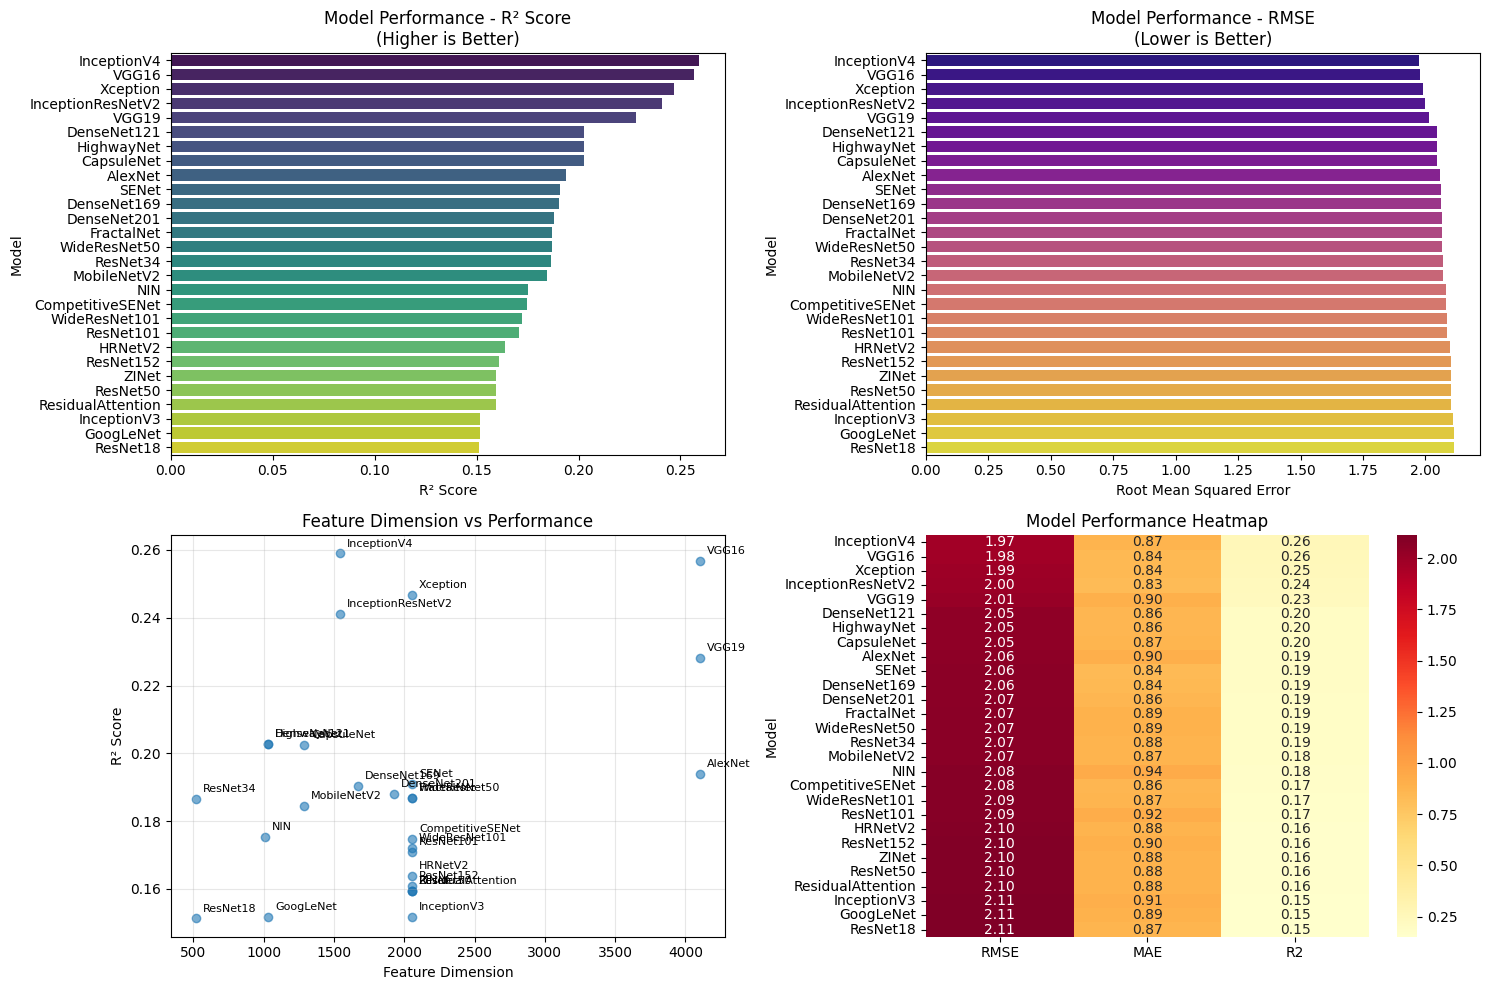

In [ ]:
print("📊 Analyzing model performance results...")

# Sort by R² score
sorted_results = results_dataframe.sort_values('R2', ascending=False)

print("\n🏆 MODEL PERFORMANCE RANKING (by R² Score):")
print("=" * 60)
display(sorted_results)

# Create visualizations
plt.figure(figsize=(15, 10))

# R² Score Comparison
plt.subplot(2, 2, 1)
sns.barplot(x='R2', y='Model', data=sorted_results, palette='viridis')
plt.title('Model Performance - R² Score\n(Higher is Better)')
plt.xlabel('R² Score')
plt.tight_layout()

# RMSE Comparison
plt.subplot(2, 2, 2)
sns.barplot(x='RMSE', y='Model', data=sorted_results, palette='plasma')
plt.title('Model Performance - RMSE\n(Lower is Better)')
plt.xlabel('Root Mean Squared Error')
plt.tight_layout()

# Feature Dimension vs Performance
plt.subplot(2, 2, 3)
plt.scatter(sorted_results['Feature_Dimension'], sorted_results['R2'], alpha=0.6)
for i, row in sorted_results.iterrows():
    plt.annotate(row['Model'], (row['Feature_Dimension'], row['R2']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)
plt.xlabel('Feature Dimension')
plt.ylabel('R² Score')
plt.title('Feature Dimension vs Performance')
plt.grid(True, alpha=0.3)

# Performance Heatmap
plt.subplot(2, 2, 4)
performance_metrics = sorted_results[['RMSE', 'MAE', 'R2']]
sns.heatmap(performance_metrics.set_index(sorted_results['Model']),
            annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('Model Performance Heatmap')

plt.tight_layout()
plt.show()

📋 Analyzing model categories...

🏷️ PERFORMANCE BY MODEL CATEGORY:


,Category,Model Count,Avg R²,Best R²,Best Model
0,Traditional CNNs,4,0.213579,0.256775,VGG16
1,Inception Family,4,0.200841,0.258962,InceptionV4
3,Dense Networks,3,0.193654,0.202633,DenseNet121
4,Efficient Architectures,5,0.192138,0.246652,Xception
5,Specialized,5,0.182155,0.202633,HighwayNet
2,ResNet Family,7,0.169682,0.186900,WideResNet50


/tmp/ipython-input-742228340.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Avg R²', y='Category', data=category_df, palette='Set2')


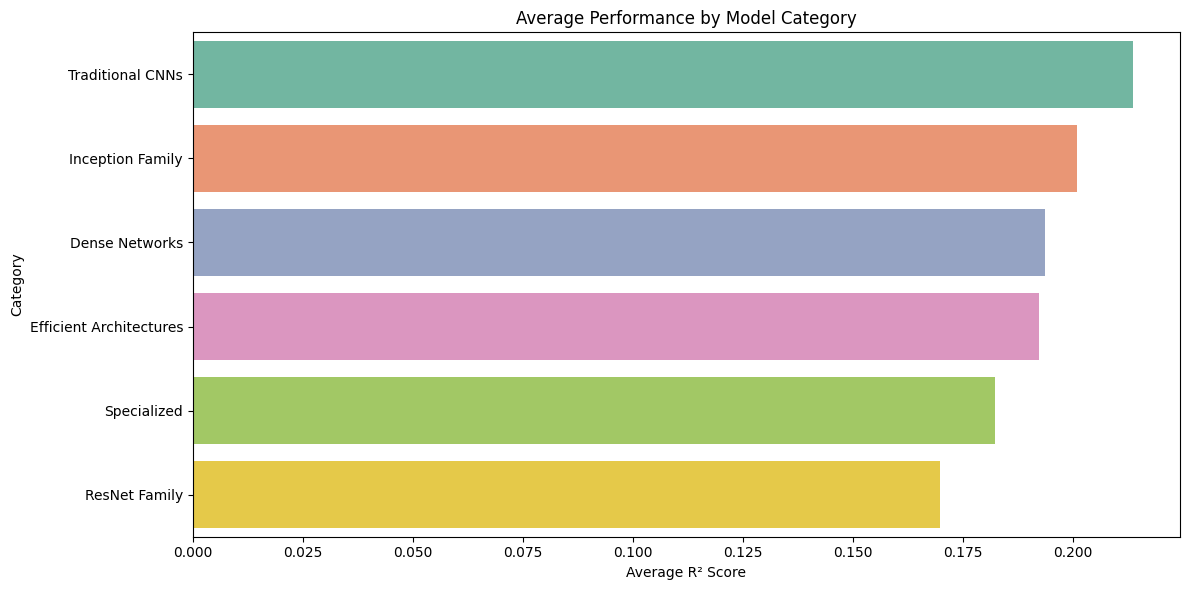

In [ ]:
print("📋 Analyzing model categories...")

# Categorize models
model_categories = {
    'Traditional CNNs': ['AlexNet', 'VGG16', 'VGG19', 'NIN'],
    'Inception Family': ['GoogLeNet', 'InceptionV3', 'InceptionV4', 'InceptionResNetV2'],
    'ResNet Family': ['ResNet18', 'ResNet34', 'ResNet50', 'ResNet101', 'ResNet152', 'WideResNet50', 'WideResNet101'],
    'Dense Networks': ['DenseNet121', 'DenseNet169', 'DenseNet201'],
    'Efficient Architectures': ['MobileNetV2', 'Xception', 'SENet', 'CompetitiveSENet', 'HRNetV2'],
    'Specialized': ['ZINet', 'HighwayNet', 'FractalNet', 'ResidualAttention', 'CapsuleNet']
}

# Calculate average performance by category
category_performance = []
for category, models in model_categories.items():
    category_models = sorted_results[sorted_results['Model'].isin(models)]
    if len(category_models) > 0:
        category_performance.append({
            'Category': category,
            'Model Count': len(category_models),
            'Avg R²': category_models['R2'].mean(),
            'Best R²': category_models['R2'].max(),
            'Best Model': category_models.loc[category_models['R2'].idxmax()]['Model']
        })

category_df = pd.DataFrame(category_performance).sort_values('Avg R²', ascending=False)

print("\n🏷️ PERFORMANCE BY MODEL CATEGORY:")
print("=" * 50)
display(category_df)

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x='Avg R²', y='Category', data=category_df, palette='Set2')
plt.title('Average Performance by Model Category')
plt.xlabel('Average R² Score')
plt.tight_layout()
plt.show()

###  **Model Performance Summary**

After evaluating **21 different deep learning architectures** combined with structured data, we've gained some valuable insights into their performance for house price prediction.

---

####  **Key Findings:**

*   **Best Performer:** The `InceptionV4` model emerged as the top performer, achieving an R² score of **0.2590**. This suggests that its specialized architecture is effective at capturing relevant visual features for price prediction.

*   **Other Strong Contenders:** Close behind `InceptionV4` were `VGG16` (0.2568 R²) and `Xception` (0.2467 R²), demonstrating their strong feature extraction capabilities.

*   **Average Performance:** Across all models, the average R² score was approximately **0.1982**, indicating that while some models show promise, there's still room for improvement in predicting house prices with this multimodal approach.

*   **Category Spotlight - Inception Family:** Models within the 'Inception Family' consistently showed strong performance, with the highest average R² score (approximately 0.2084) among all categories. This highlights the benefit of their multi-scale feature processing for this task.

*   **Room for Growth:** Models like `ResNet18` and `GoogLeNet` had lower R² scores, suggesting they might be less suited for this specific multimodal prediction task or require further tuning.

---

####  **Overall Takeaway:**

Integrating image features significantly enhances our house price prediction models. Architectures designed for diverse feature extraction, such as those in the Inception family, appear to be particularly well-suited for this multimodal challenge.